# use this notebook to test trained models (trained on 3 band images) and generate plots

# imports

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import glob
import os
import scipy
from astropy.io import fits
import importlib.util
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib.backends.backend_pdf
import re
import copy

# define functions

In [2]:
def load_module(path):
    spec = importlib.util.spec_from_file_location("module.name", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_arch(arch_path, bands):
    arch = load_module(arch_path)
    nn = arch.CNN()

    g = tf.Graph()
    with g.as_default():
        nn.create_architecture(bands=bands) # NEED TO ADJUST TO WORK WITH 3 BANDS
    return g, nn

def load_backup(sess, graph, backup):
    with graph.as_default():
        saver = tf.train.Saver()
        saver.restore(sess, backup)
        
def prepare_calc(images):
    images[images==100] = 0
    images = (images - images.mean()) / images.std()
    return images

def prepare_hard(images):
    images[images==100] = 0
    images = (images - 2.020e-12) / 5.391e-11
    return images

In [3]:
def tpr_fpr_auc(predictions, targets):
    '''
    Returns tpr, fpr, auc for given predictions with targets.
    '''
    num_0s = 0
    num_1s = 0
    for t in targets:
        if int(t) == 0:
            num_0s += 1
        if int(t) == 1:
            num_1s += 1
    step_tpr = float(1/num_1s)
    step_fpr = float(1/num_0s)
    tpr_pts = [1]
    fpr_pts = [1]
    for pred in sorted(predictions):
        threshold = pred
        tpr = 0.
        fpr = 0.
        for p,t in zip(predictions, targets):
            if p > threshold and int(t) == 1:
                fpr += step_tpr
            if p > threshold and int(t) == 0:
                tpr += step_fpr
        tpr_pts.append(tpr)
        fpr_pts.append(fpr)
    ret_auc = metrics.auc(tpr_pts, fpr_pts)
    
    return tpr_pts, fpr_pts, ret_auc

In [4]:
def roc_manual(tpr, fpr, auc, auc_type=False, title=False, savefig=False):
    '''
    Plot ROC curve with given values.
    '''
    if auc_type == False:
        auc_type = ['']*len(tpr) # initialize empty if not give to work with zip()
    plt.figure(figsize=(10,10))
    if title != False: # check for title
        plt.title(title, fontsize=15)
    else:
        plt.title('ROC', fontsize=15)
    plt.plot([0,1], [0,1], 'r--') # 45deg line
    for t,f,a,at in zip(tpr,fpr,auc,auc_type): # go through lists
        plt.plot(t, f, label='{} AUC = {:.2f}%'.format(at, a*100))
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.legend(loc='lower right', fontsize=15)
    plt.show()

In [5]:
def plot_roc(outfile, model, sess, x, y, idx=False, labels=False, savefig=False, title=False):
    # x should be list of x arrays to test
    if labels == False:
        labels = ['dataset {}'.format(i) for i in range(len(x))]
        
    plt.figure(figsize=(15,8))
    if title != False and idx == False:
        plt.title(title)
    elif title == False and idx != False:
        plt.title('LASTRO ROC {}'.format(idx))
    elif title != False and idx != False:
        plt.title('{}  ({})'.format(title, idx))
    else:
        plt.title('LASTRO ROC')
    plt.plot([0,1], [0,1], 'r--')
    for data, label in zip(x, labels):
        preds = model.predict(sess, data)
        fpr, tpr, threshold = metrics.roc_curve(y, preds)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} AUC = {:0.2f}%'.format(label,roc_auc*100))
    plt.legend(loc='lower right')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    if savefig == True and idx != False:
        plt.savefig(outfile+'plots/ROC_{}.pdf'.format(idx))
    if savefig == True and idx == False:
        plt.savefig(outfile+'plots/ROC.jpg')
    plt.show()
    return

In [6]:
def plot_auc(outfile, arch_path, bands, n_train_model, plot_xent=False, get_unseen=False, x_test=False, y_test=False, n_iters=False, savefig=False, title=False, stopearly=False):

    # plot AUC vs iteration using outfile metrics data
    iteration=[]
    xent_val=[]
    auc_val=[]
    xent_train=[]
    auc_train=[]
    with open(outfile+'metrics.txt') as file:
        for line in file.readlines():
            line=line.split(' ')
            if line[0] != '#':
                iteration.append(int(line[0]))
                xent_val.append(float(line[1]))
                auc_val.append(float(line[2]))
                xent_train.append(float(line[3]))
                auc_train.append(float(line[4]))
                
    # plot auc by recalculating auc with new models on totally unseen data
    auc_test_up=[]
    auc_test_pc=[]
    auc_test_nnp=[]
    auc_iterations=[]
    model_files=[]
    if get_unseen == True:
        # get all models
        for idx, f in enumerate(sorted(os.listdir(outfile+'iter/'))):
            if stopearly != False:
                if idx == stopearly:
                    break
            if f.endswith('.data.data-00000-of-00001'):
                model_files.append(f)
        # plot specified amount of model iterations
        step = int(len(model_files)/n_iters)
        for i in range(n_iters):
            # get iteration list
            auc_iterations.append(int(model_files[i*step][:6]))
            # load in i model version
            graph, nn = load_arch(arch_path, bands)
            sess = tf.Session(graph=graph)
            load_backup(sess, graph, outfile+'iter/{}'.format(model_files[i*step][:11]))
            # unprepared data
            x_up = x_test
            preds_up = nn.predict(sess, x_up)
            fpr_up, tpr_up, threshold_up = roc_curve(y_test, preds_up)
            roc_auc_up = auc(fpr_up, tpr_up)
            auc_test_up.append(roc_auc_up)
            # prepare_calc
            x_pc = prepare_calc(x_test)
            preds_pc = nn.predict(sess, x_pc)
            fpr_pc, tpr_pc, threshold_pc = roc_curve(y_test, preds_pc)
            roc_auc_pc = auc(fpr_pc, tpr_pc)
            auc_test_pc.append(roc_auc_pc)
            # nn.prepare
            x_nnp = nn.prepare(x_test)
            preds_nnp = nn.predict(sess, x_nnp)
            fpr_nnp, tpr_nnp, threshold_nnp = roc_curve(y_test, preds_nnp)
            roc_auc_nnp = auc(fpr_nnp, tpr_nnp)
            auc_test_nnp.append(roc_auc_nnp)

    plt.figure(figsize=(15,10))
    if title != False:
        plt.title(title)
    else:
        plt.title('LASTRO AUC for model trained on {} images'.format(n_train_model))
    plt.plot(iteration, auc_val, c='red', label='AUC VALIDATION (best: {:.3f}%)'.format(max(auc_val)*100))
    plt.plot(iteration, auc_train, c='blue', label='AUC TRAIN (best: {:.3f}%)'.format(max(auc_train)*100))
    if get_unseen:
        plt.plot(auc_iterations, auc_test_up, label='UNPREPARED AUC TEST (best: {:.3f}%)'.format(max(auc_test_up)*100))
        plt.plot(auc_iterations, auc_test_pc, label='PREPARE CALC AUC TEST (best: {:.3f}%)'.format(max(auc_test_pc)*100))
        plt.plot(auc_iterations, auc_test_nnp, label='NN.PREPARE AUC TEST (best: {:.3f}%)'.format(max(auc_test_nnp)*100))
    if plot_xent:
        plt.plot(iteration, xent_val, label='XENT VALIDATION')
        plt.plot(iteration, xent_train, label='XENT TRAIN')
    plt.legend(loc='lower right', prop={'size': 12})
    plt.xlim([100,10000])
    plt.ylim([0,1.05])
    plt.xticks(range(0,10001,1000))
    plt.ylabel('AUC')
    plt.xlabel('Iteration')
    if savefig == True and savefig != False:
        plt.savefig(outfile+'plots/AUC.jpg')
    if savefig != True and savefig != False:
        plt.savefig(outfile+'plots/{}'.format(savefig))
    plt.show()
    return

# get data

### ground-based challenge set [npz]

In [7]:
# get total challenge data set for testing
bands = 3
npz_path = '/Users/mac/Desktop/LBNL/challenge_data/GroundBasedTraining/npz/'
files = sorted(glob.glob(npz_path+'*.npz'))
x = np.zeros((len(files), 101, 101, bands))
y = np.zeros((len(files),))

for i,f in enumerate(files):
    if i%1000 == 0 and i != 0:
        print(i, 'images collected')
    with np.load(f) as data:
        im = data['image'][:,:,:bands]
        target = data['is_lens']
    x[i] = im
    y[i] = target
    
print('x shape:', x.shape)
print('y shape:', y.shape)
print('collected {} challenge data images for testing'.format(20000))

1000 images collected
2000 images collected
3000 images collected
4000 images collected
5000 images collected
6000 images collected
7000 images collected
8000 images collected
9000 images collected
10000 images collected
11000 images collected
12000 images collected
13000 images collected
14000 images collected
15000 images collected
16000 images collected
17000 images collected
18000 images collected
19000 images collected
x shape: (20000, 101, 101, 3)
y shape: (20000,)
collected 20000 challenge data images for testing


### decals [npz]

In [8]:
# get all decals images
npz_decals = '/Users/mac/Desktop/LBNL/lensfinder-euclid-master/npz_3band_decals/'
files_decals = sorted(glob.glob(npz_decals+'*.npz'))
x_decals = np.zeros((len(files_decals), 101, 101, bands))
y_decals = np.zeros((len(files_decals),))

for i,f in enumerate(files_decals):
    if i%1000 == 0 and i != 0:
        print(i, 'images collected')
    with np.load(f) as data:
        im = data['image']
        im = np.transpose(im, (1,2,0))
        target = data['is_lens']
    x_decals[i] = im
    y_decals[i] = target
    
print('x_decals shape:', x_decals.shape)
print('y_decals shape:', y_decals.shape)
print('collected {} decals data images for testing'.format(len(files_decals)))

x_decals shape: (0, 101, 101, 3)
y_decals shape: (0,)
collected 0 decals data images for testing


### decals dataset from chris (81 lens/200 nonlens)

In [9]:
# get decals nonlens using chris' indices
nonlensfile = np.load('/Users/mac/Desktop/LBNL/CMUDeepLens-master/chris/LBNL_key_items-master/notebooks/selected_train_images.npy')
decals_nonlens200 = np.zeros((200, 101, 101, bands))
y_nonlens200 = np.zeros((200,))

for i,idx in enumerate(nonlensfile):
    data = np.load(files_decals[int(idx)])
    assert int(data['is_lens']) == 0
    im = data['image']
    im = np.transpose(im, (1,2,0))
    decals_nonlens200[i] = im
    y_nonlens200[i] = 0

print('collected {} decals nonlens images for testing'.format(200))

IndexError: list index out of range

In [ ]:
# get decals lenses using 
decals_lens81 = np.zeros((81, 101, 101, bands))
y_lens81 = np.ones((81,))

lens_folder = '/Users/mac/Desktop/LBNL/decals/decals_test_set/DECals_set/Train/fits_images/'
lfitsfiles = os.listdir(lens_folder)
for i, f in enumerate(lfitsfiles):
    with fits.open(lens_folder+lfitsfiles[i]) as data:
        im = data[0].data
        im = np.transpose(im, (1,2,0))
        decals_lens81[i] = im

print('collected {} decals lens images for testing'.format(81))

In [ ]:
decals_set_281 = np.concatenate((decals_lens81, decals_nonlens200))
y_decals_set_281 = np.concatenate((y_lens81, y_nonlens200))
print(decals_set_281.shape, y_decals_set_281.shape)

## check dataset images

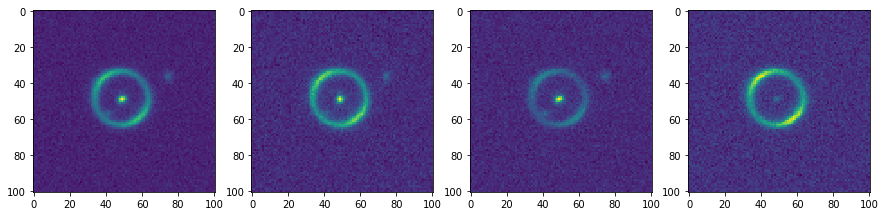

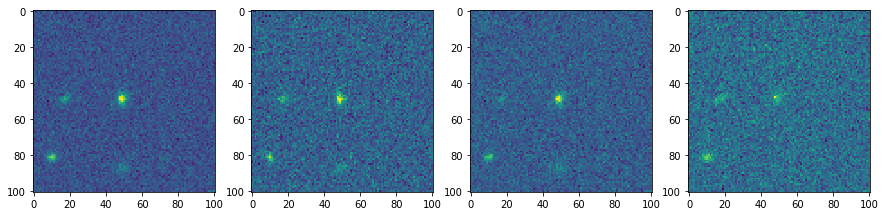

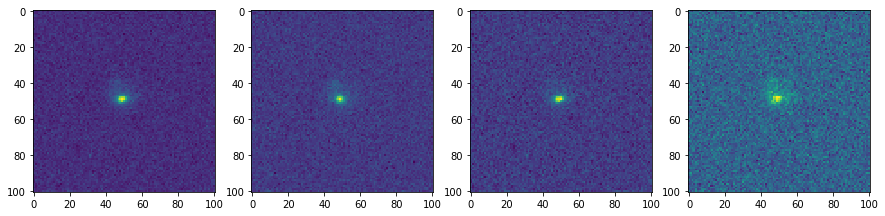

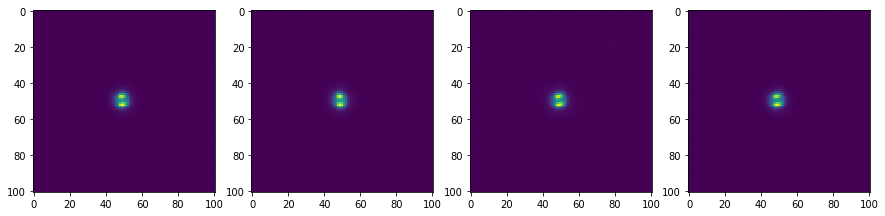

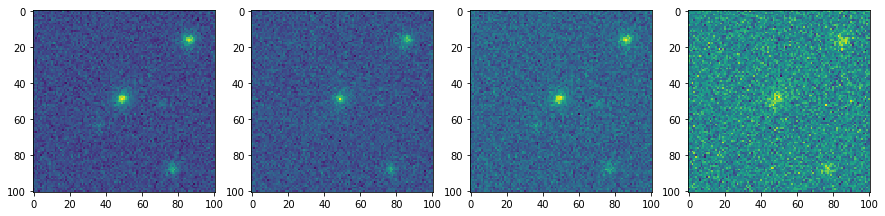

In [159]:
# view test images
for img in x[:5]:
    plt.figure(figsize=(15,10))
    plt.subplot(141)
    equal = img[:,:,0]*0.3+img[:,:,1]*0.3+img[:,:,2]*0.3
    plt.imshow(equal)
    plt.subplot(142)
    plt.imshow(img[:,:,0])
    plt.subplot(143)
    plt.imshow(img[:,:,1])
    plt.subplot(144)
    plt.imshow(img[:,:,2])

(81, 101, 101, 3)


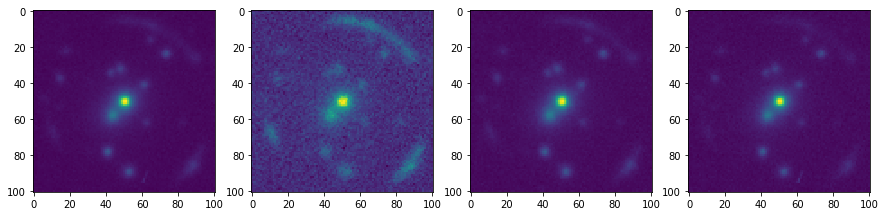

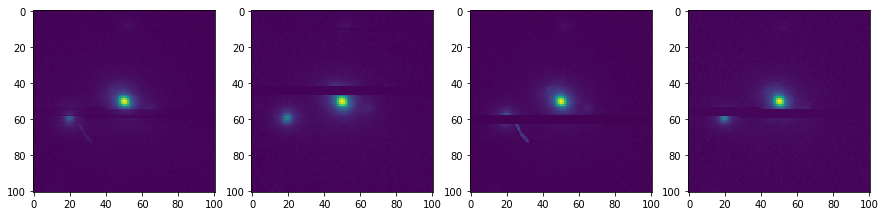

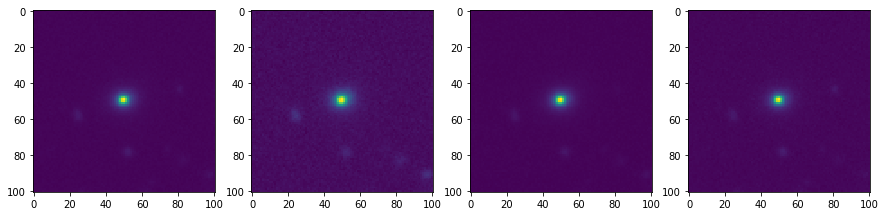

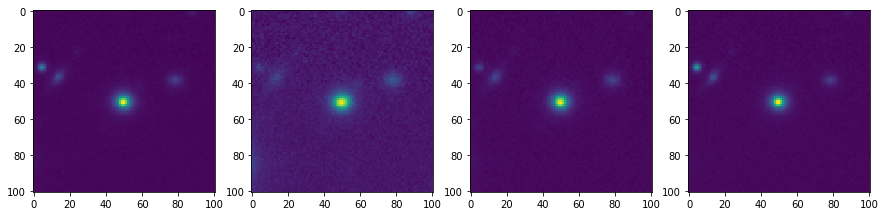

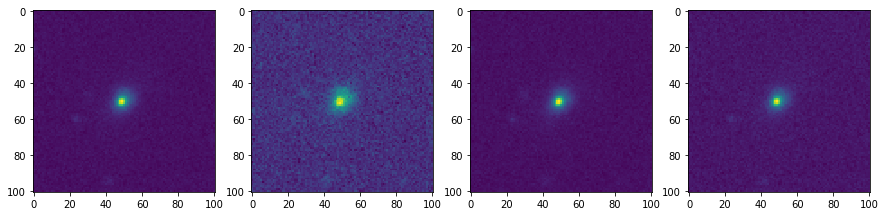

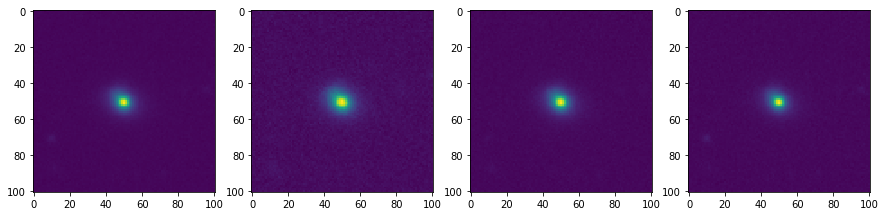

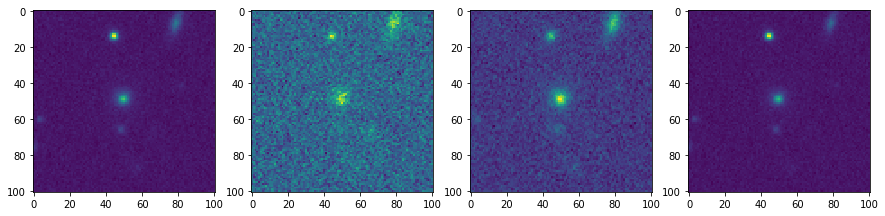

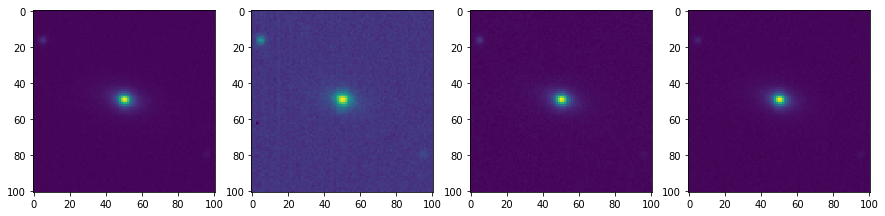

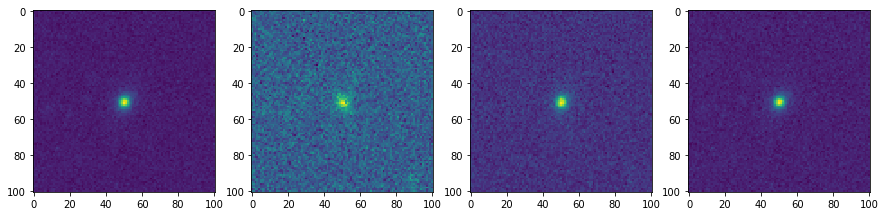

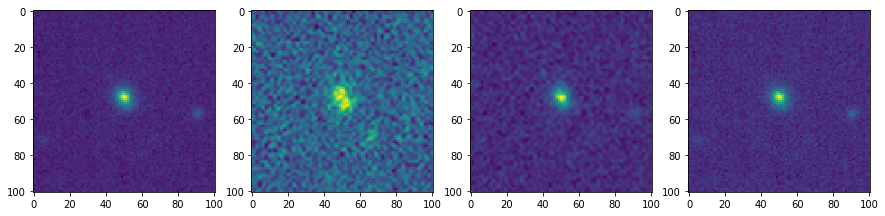

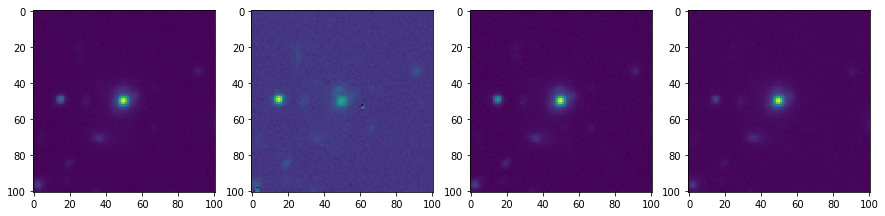

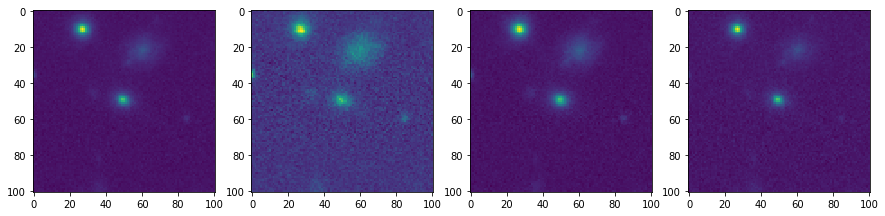

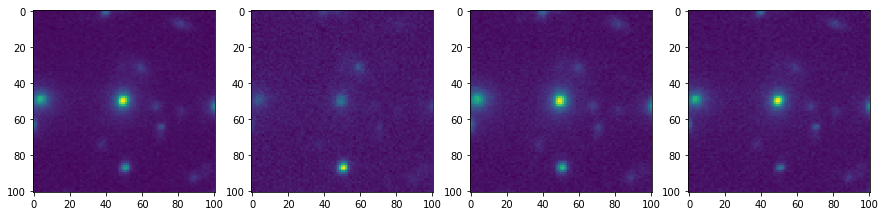

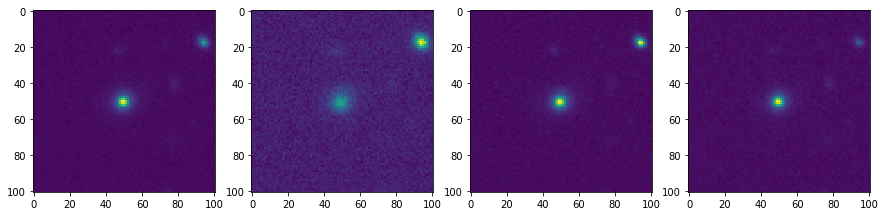

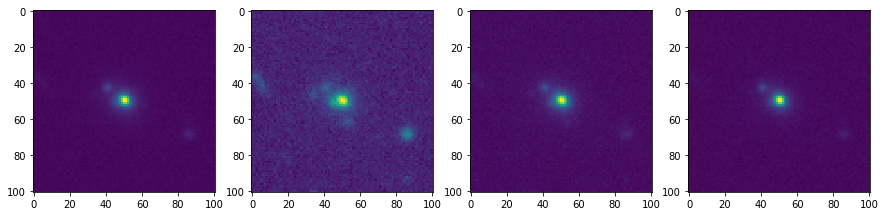

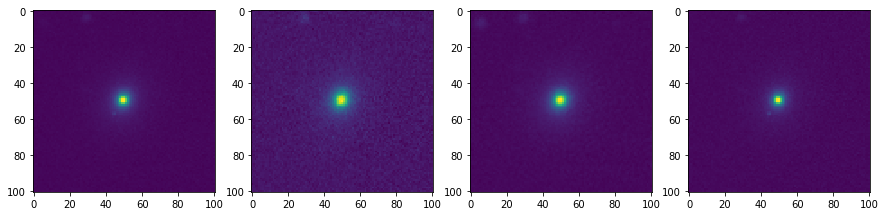

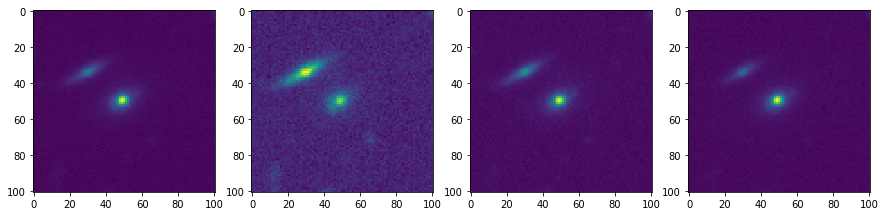

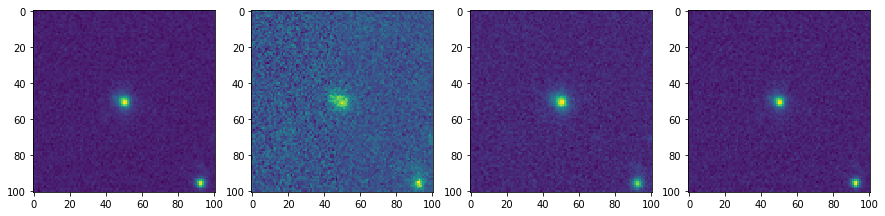

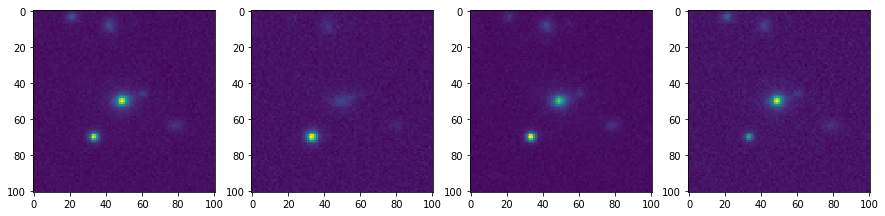

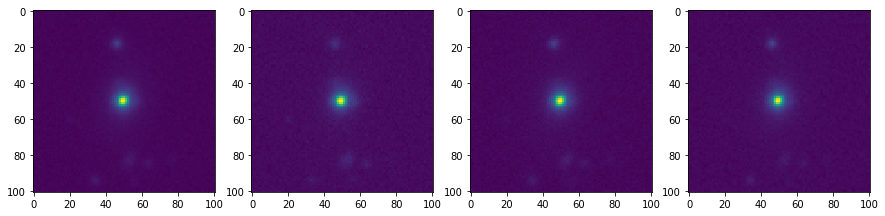

In [223]:
# check decals lenses
print(decals_lens81.shape)
for img in decals_lens81[:20]:
    plt.figure(figsize=(15,10))
    plt.subplot(141)
    equal = img[:,:,0]*0.3+img[:,:,1]*0.3+img[:,:,2]*0.3
    plt.imshow(equal)
    plt.subplot(142)
    plt.imshow(img[:,:,0])
    plt.subplot(143)
    plt.imshow(img[:,:,1])
    plt.subplot(144)
    plt.imshow(img[:,:,2])
    plt.show

(200, 101, 101, 3)


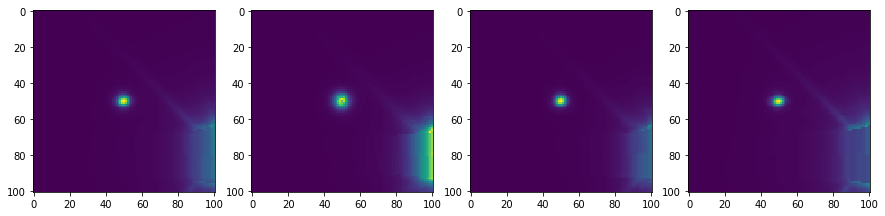

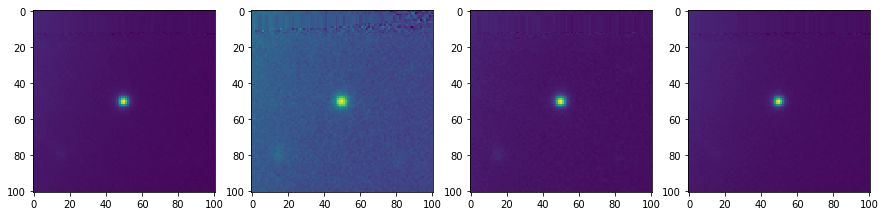

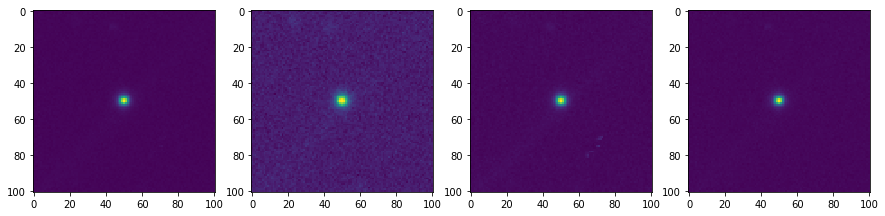

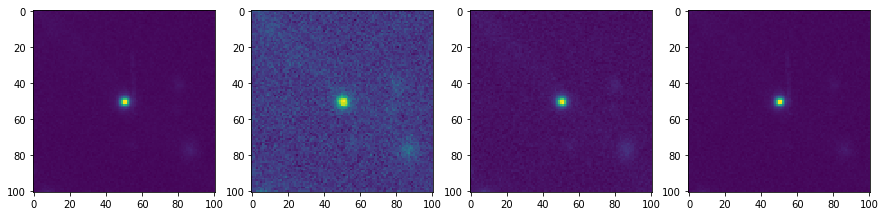

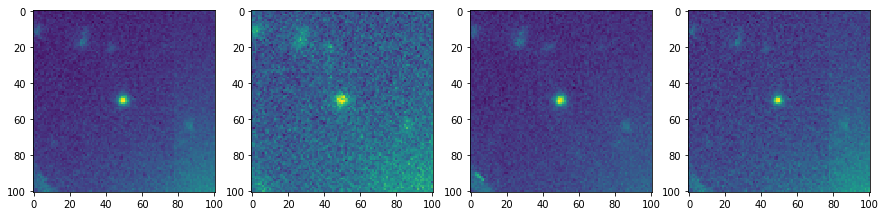

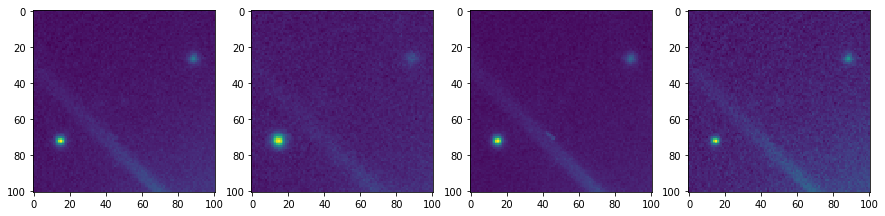

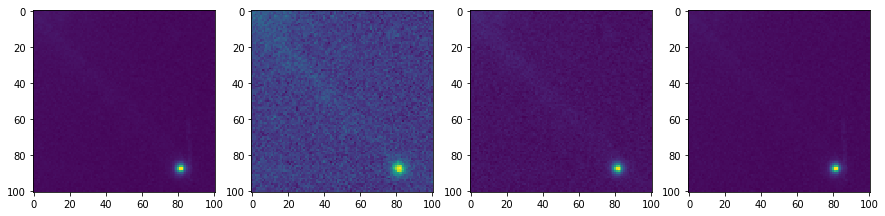

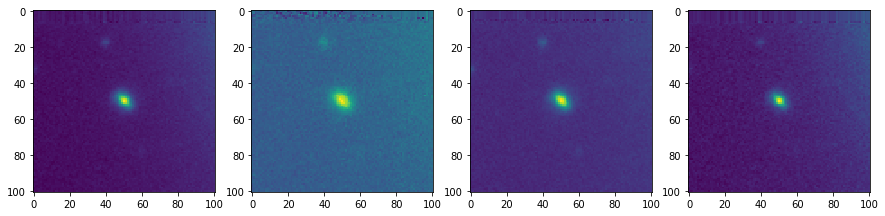

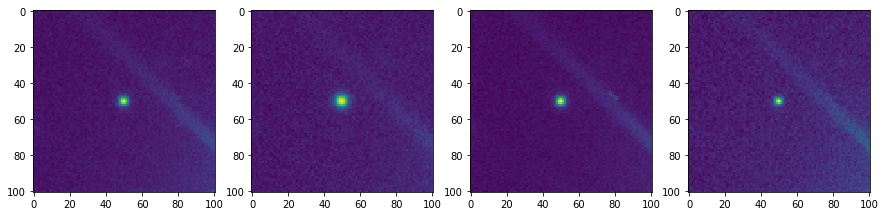

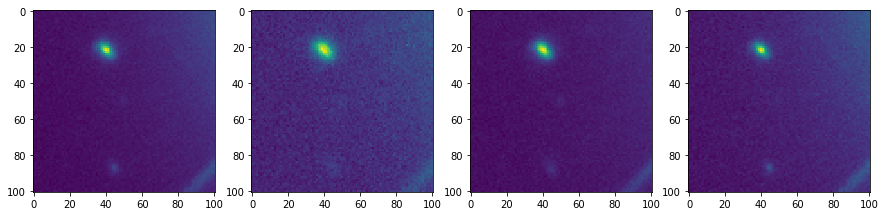

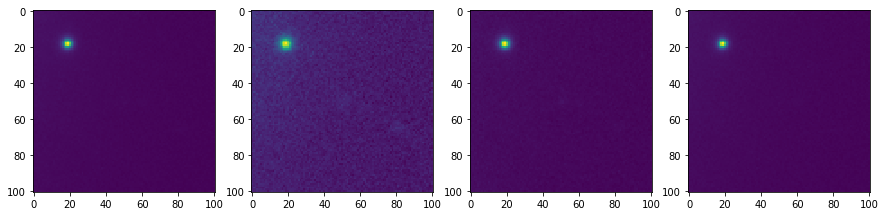

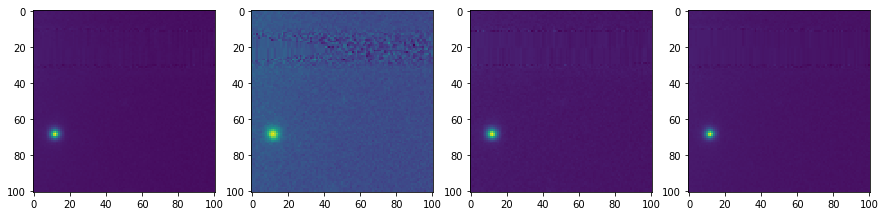

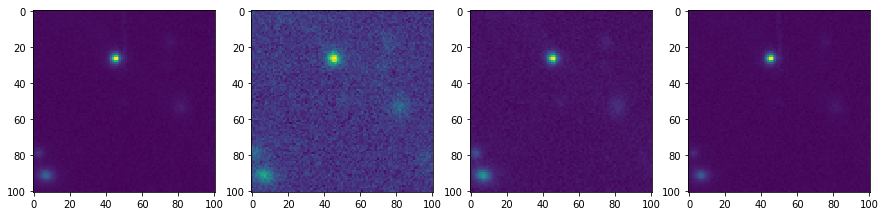

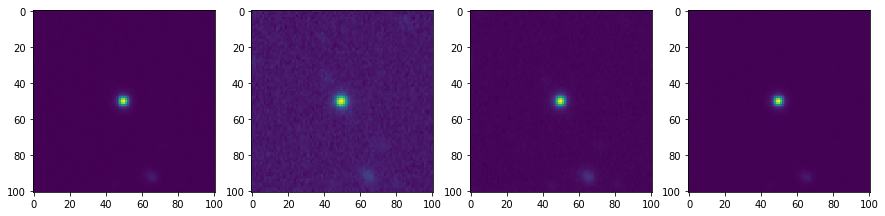

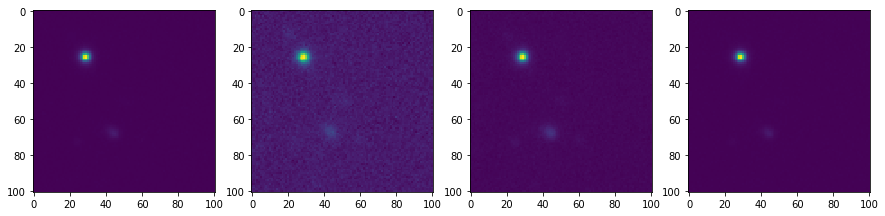

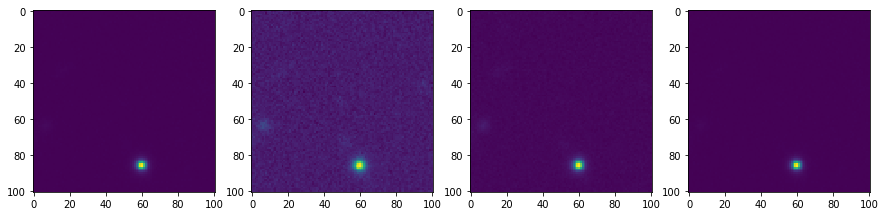

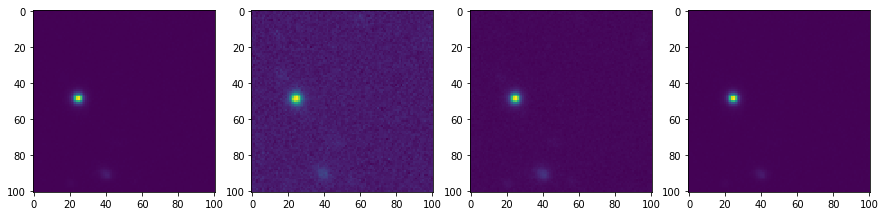

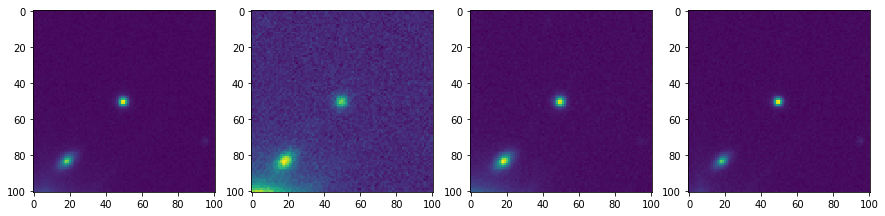

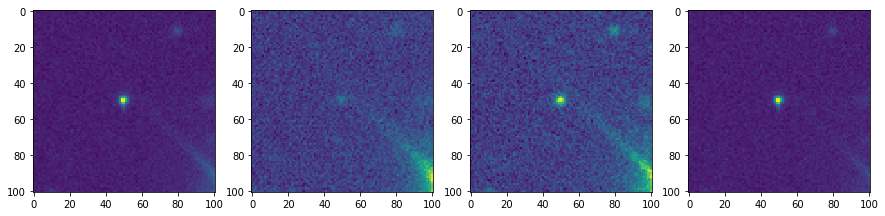

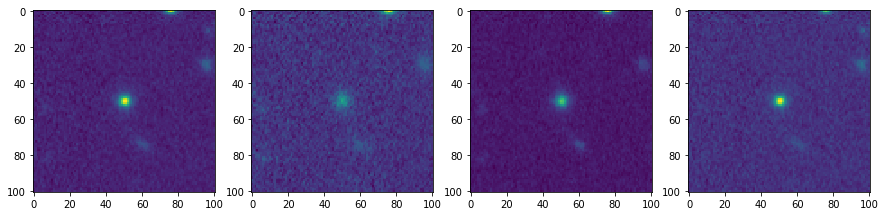

In [224]:
# check decals nonlenses
print(decals_nonlens200.shape)
for img in decals_nonlens200[:20]:
    plt.figure(figsize=(15,10))
    plt.subplot(141)
    equal = img[:,:,0]*0.3+img[:,:,1]*0.3+img[:,:,2]*0.3
    plt.imshow(equal)
    plt.subplot(142)
    plt.imshow(img[:,:,0])
    plt.subplot(143)
    plt.imshow(img[:,:,1])
    plt.subplot(144)
    plt.imshow(img[:,:,2])
    plt.show

# load models and generate plots

#### I've left many cells up plotting various things. Some I don't use as much anymore. Scroll through plots to get to more recent ones (application becomes simpler than it is earlier on)

### load model_240 (trained on ground-based challenge data)

In [11]:
# specify variables for model_240, load in base architecture, initialize with values
outfile_240 = '/Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/'
arch_path = 'arch_baseline_amount_3band.py'
iteration = '010000'
bands = 3

graph_240, nn_240 = load_arch(arch_path, bands)
sess_240 = tf.Session(graph=graph_240)
load_backup(sess_240, graph_240, outfile_240+'iter/{}.data'.format(iteration))

INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/010000.data


InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/010000.data: Not found: /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter
	 [[Node: save/RestoreV2_112 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_112/tensor_names, save/RestoreV2_112/shape_and_slices)]]

Caused by op 'save/RestoreV2_112', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-cff26684e46d>", line 9, in <module>
    load_backup(sess_240, graph_240, outfile_240+'iter/{}.data'.format(iteration))
  File "<ipython-input-2-cc877bf2f6b8>", line 18, in load_backup
    saver = tf.train.Saver()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 669, in restore_v2
    dtypes=dtypes, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/010000.data: Not found: /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter
	 [[Node: save/RestoreV2_112 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_112/tensor_names, save/RestoreV2_112/shape_and_slices)]]


### load model_10000 (trained on ground-based challenge data)

In [12]:
# specify variables for model_10000, load in base architecture, initialize with values
outfile_10000 = '/Users/mac/Desktop/LBNL/LASTRO/saved_models/output_10000_10000_3band_finished/'
arch_path = '/Users/mac/Desktop/LBNL/LASTRO/lensfinder-euclid-master/arch_baseline_amount_3band.py'
iteration = '010000'
bands = 3

graph_10000, nn_10000 = load_arch(arch_path, bands)
sess_10000 = tf.Session(graph=graph_10000)
load_backup(sess_10000, graph_10000, outfile_10000+'iter/{}.data'.format(iteration))

INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/LASTRO/saved_models/output_10000_10000_3band_finished/iter/010000.data


### load model_320_1 [50,000 ITERATIONS] (trained on ground-based challenge data)

In [243]:
# specify variables for model_10000, load in base architecture, initialize with values
outfile_320_1 = '/Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_50000_320_1_3band_finished/'
arch_path = 'arch_baseline_amount_3band.py'
iteration = '050000'
bands = 3

graph_320_1, nn_320_1 = load_arch(arch_path, bands)
sess_320_1 = tf.Session(graph=graph_320_1)
load_backup(sess_320_1, graph_320_1, outfile_320_1+'iter/{}.data'.format(iteration))

INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_50000_320_1_3band_finished/iter/050000.data


### load model_320_2 [10,000 ITERATIONS] (trained on ground-based challenge data)

In [18]:
# specify variables for model_10000, load in base architecture, initialize with values
outfile_320_2 = '/Users/mac/Desktop/LBNL/LASTRO/saved_models/output_10000_320_2_3band_finished/'
arch_path = '/Users/mac/Desktop/LBNL/LASTRO/lensfinder-euclid-master/arch_baseline_amount_3band.py'
iteration = '010000'
bands = 3

graph_320_2, nn_320_2 = load_arch(arch_path, bands)
sess_320_2 = tf.Session(graph=graph_320_2)
load_backup(sess_320_2, graph_320_2, outfile_320_2+'iter/{}.data'.format(iteration))

INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/LASTRO/saved_models/output_10000_320_2_3band_finished/iter/010000.data


### load model_320_3 [10,000 ITERATIONS] (trained on ground-based challenge data)

In [249]:
# specify variables for model_10000, load in base architecture, initialize with values
outfile_320_3 = '/Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_320_3_3band_finished/'
arch_path = 'arch_baseline_amount_3band.py'
iteration = '010000'
bands = 3

graph_320_3, nn_320_3 = load_arch(arch_path, bands)
sess_320_3 = tf.Session(graph=graph_320_3)
load_backup(sess_320_3, graph_320_3, outfile_320_3+'iter/{}.data'.format(iteration))

INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_320_3_3band_finished/iter/010000.data


### plot roc for model_320_1 on ground-based images (sets of 1000)

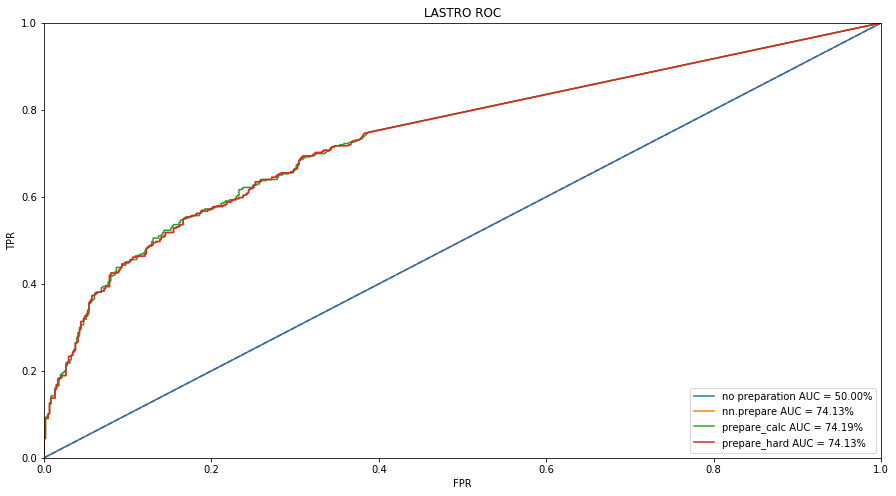

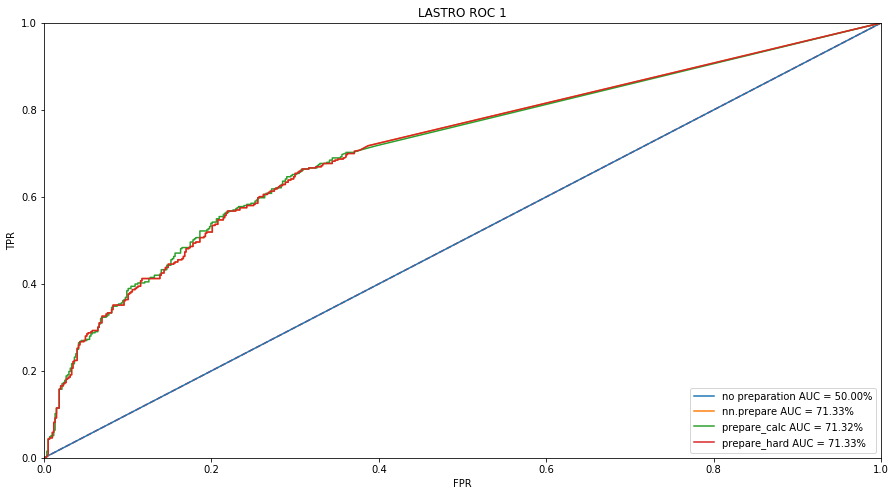

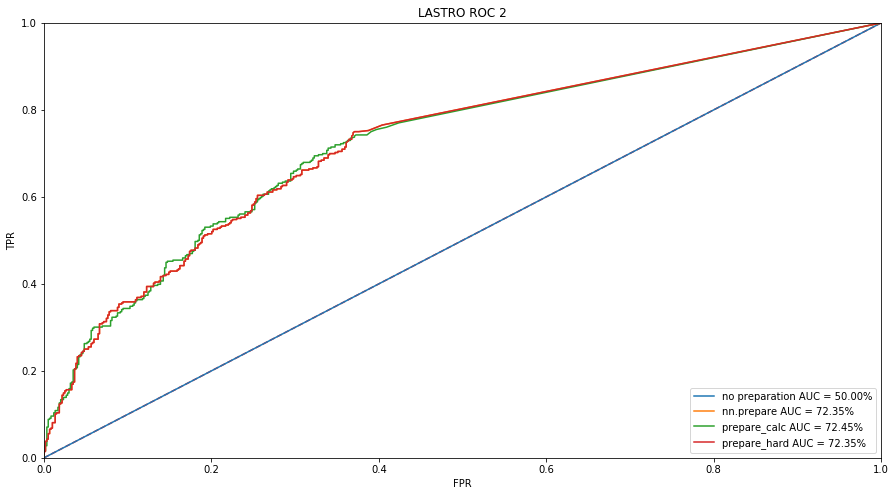

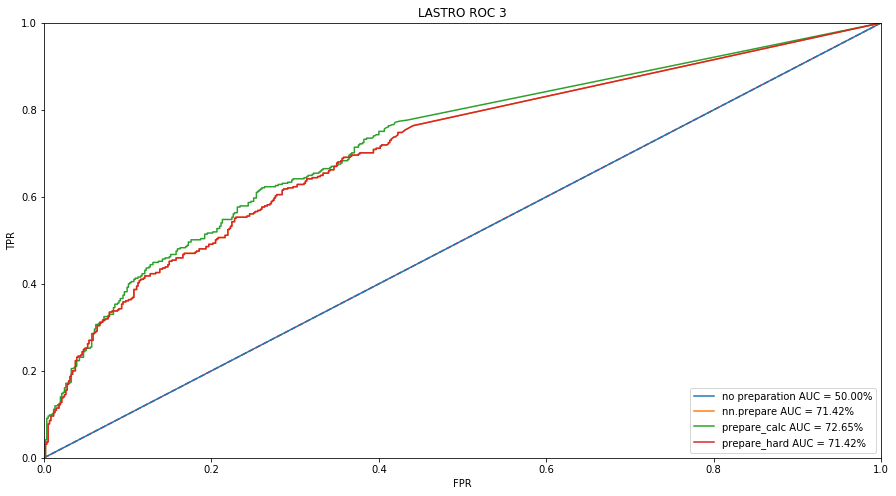

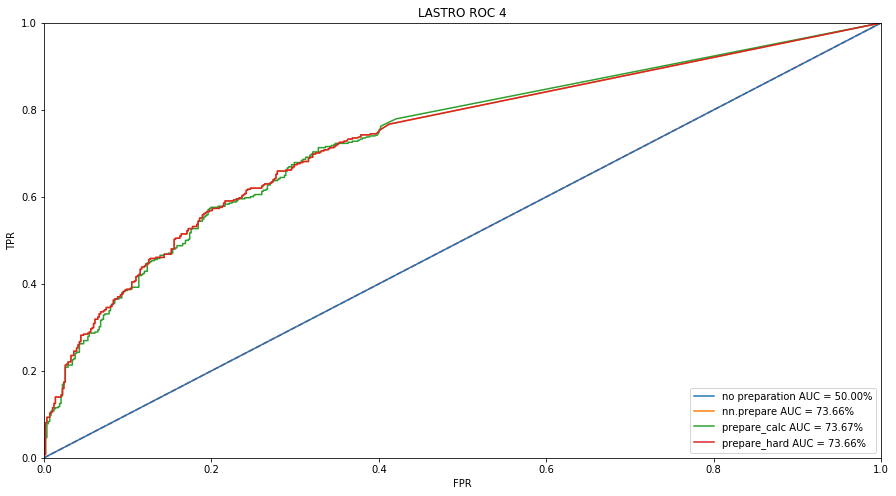

In [92]:
# plot 5 ROC curves for finished LASTRO model_320_1, with 500img sets
for i in range(5):
    y_test = y[10000+(i*500):10500+(i*500)]
    x_np = x[10000+(i*500):10500+(i*500)]
    x_p = nn_320_1.prepare(x_np)
    x_pc = prepare_calc(x_np)
    x_tests = [x_np, x_p, x_pc]
    labels = ['no preparation', 'model.prepare', 'prepare_calc']
    plot_roc(outfile_320_1, nn_320_1, sess_320_1, x_tests, y_test, idx=i+1, title='ROC for model 320_1\n(50,000 iterations, 320 gb train images)', labels=labels, savefig=False)

### plot auc for model_240 with different preparation methods

INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/000100.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/000600.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/001100.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/001600.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/002100.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/002600.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/003100.data
INFO:tensorflow:Rest

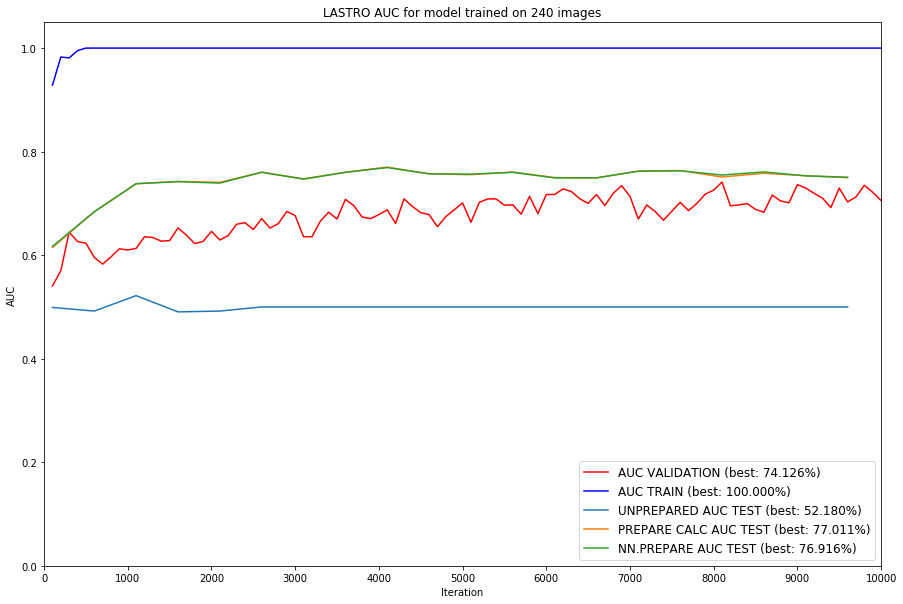

In [253]:
# plot AUC for LASTRO model_240, with 500 image set for new auc plot (unseen test data over iteration)
plot_auc(outfile_240, arch_path, bands, n_train_model=240, plot_xent=False, get_unseen=True, x_test=x[10000:10500], y_test=y[10000:10500] , n_iters=20, savefig=True)

### plot roc for model_240 on ground-based images (120 lens/120 nonlens)

got 120 lens.
got 120 nonlens.


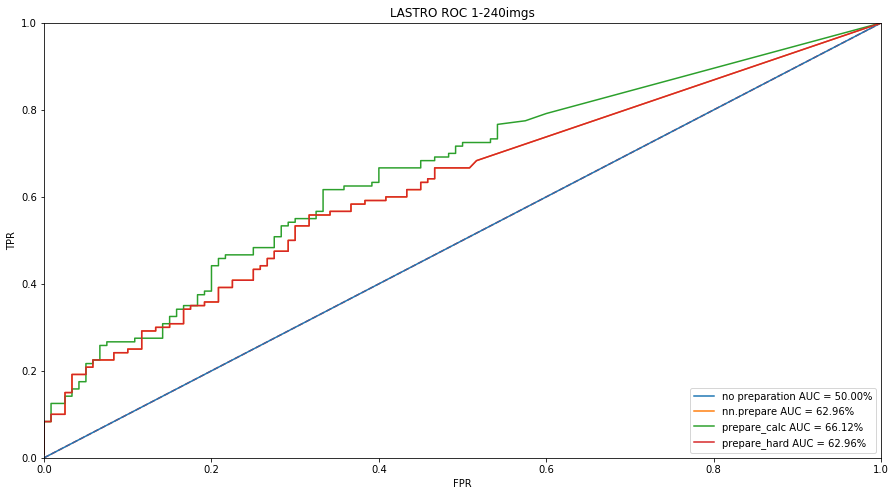

got 120 lens.
got 120 nonlens.


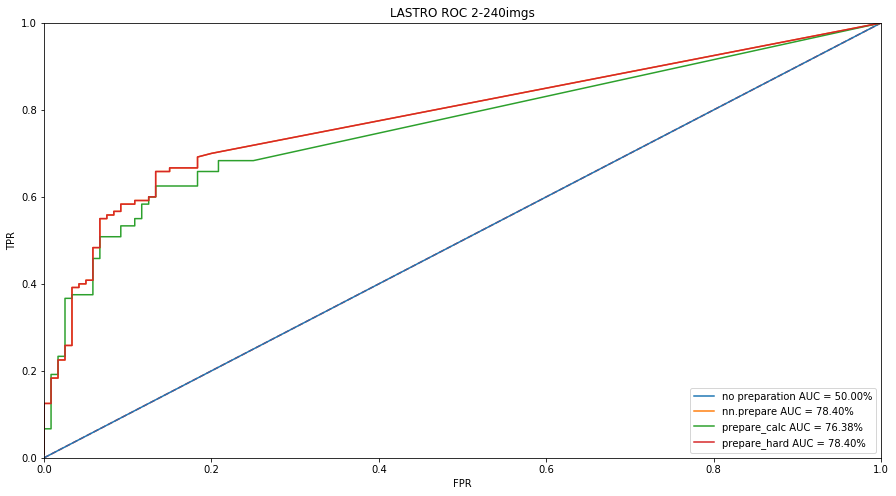

got 120 lens.
got 120 nonlens.


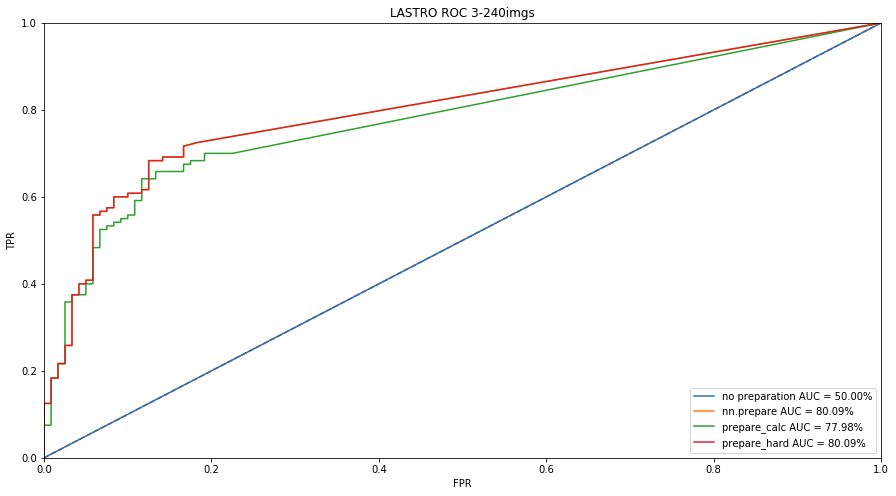

got 120 lens.
got 120 nonlens.


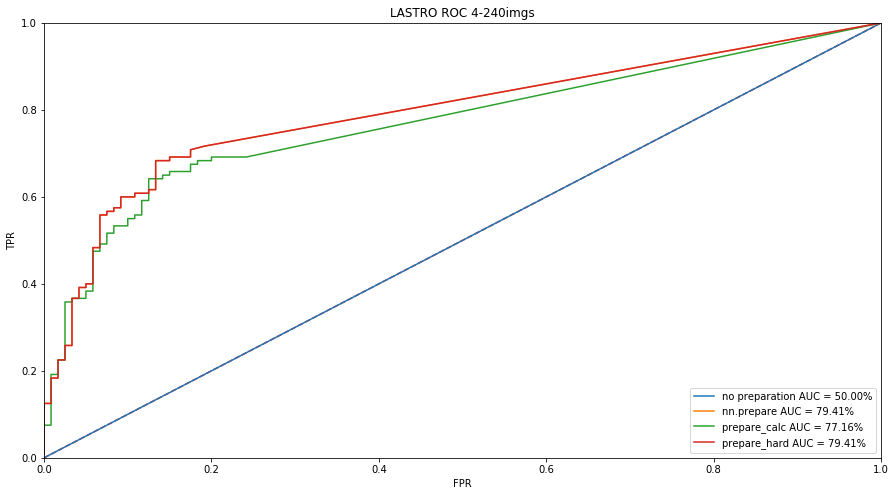

got 120 lens.
got 120 nonlens.


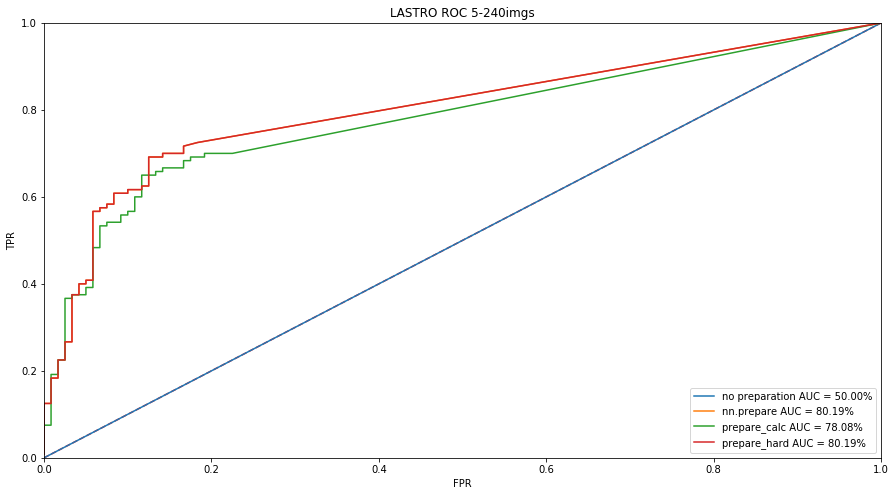

In [174]:
# PLOT ROC FOR model_240 ON 120/120 SETS
start_l = 500
start_nl = 500
for it in range(1,6):

    # get 120 lens
    lens120 = np.zeros((120, 101, 101, bands))
    found=0
    for i,f in enumerate(files[start_l:]):
        with np.load(f) as data:
            if data['is_lens'] == 1:
                im = data['image']
                lens120[found] = im[:,:,:bands]
                found += 1
        if found == 120:
            print('got 120 lens.')
            start_l = i + 1
            break
            
    # get 120 nonlens
    nonlens120 = np.zeros((120, 101, 101, bands))
    found=0
    for i,f in enumerate(files[start_nl:]):
        with np.load(f) as data:
            if data['is_lens'] == 0:
                im = data['image']
                nonlens120[found] = im[:,:,:bands]
                found += 1
        if found == 120:
            print('got 120 nonlens.')
            start_nl = i + 1
            break
            
    # make target and data arrays (dif. prep methods)
    y_it = np.concatenate((np.ones((120,)), np.zeros((120,))))
    x_it = np.concatenate((lens120, nonlens120))
    x_p = nn.prepare(x_it)
    x_pc = prepare_calc(x_it)
    x_ph = prepare_hard(x_it)
    x_its = [x_it, x_p, x_pc, x_ph]
    labels = ['no preparation', 'nn.prepare', 'prepare_calc', 'prepare_hard']
                          
    plot_roc(outfile_240, nn_240, sess_240, x_its, y_it, idx='{}-{}imgs'.format(it,240), labels=labels, savefig=True)

In [236]:
# make sure model_240 is loaded with last backup
iteration = '010000'
load_backup(sess_240, graph_240, outfile_240+'iter/{}.data'.format(iteration))

INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_10000_240_3band_finished/iter/010000.data


### plot roc for model_240 on decals images (81 lens/200 nonlens)

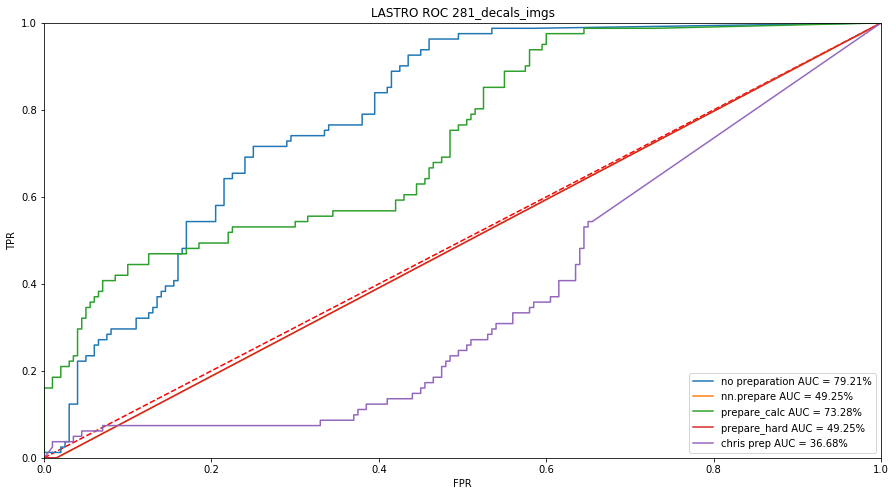

In [237]:
# plot ROC for model_240 on decals images
x_np = decals_set_281

# chris pre-processing
x_chris = decals_set_281.ravel()
x_chris*=3
clip = 5
x_chris = np.clip(x_chris, -clip, clip)*20
x_chris = x_chris.reshape(-1,101,101,3)

# other preprocessing techniques
x_p = nn.prepare(x_np)
x_pc = prepare_calc(x_np)
x_ph = prepare_hard(x_np)
x_tests = [x_np, x_p, x_pc, x_ph, x_chris]
labels = ['no preparation', 'nn.prepare', 'prepare_calc', 'prepare_hard', 'chris prep']

plot_roc(outfile_240, nn_240, sess_240, x_tests, y_decals_set_281, idx='281_decals_imgs', labels=labels, savefig=True)

### plot roc for model_10000 on decals images (81 lens/200 nonlens)

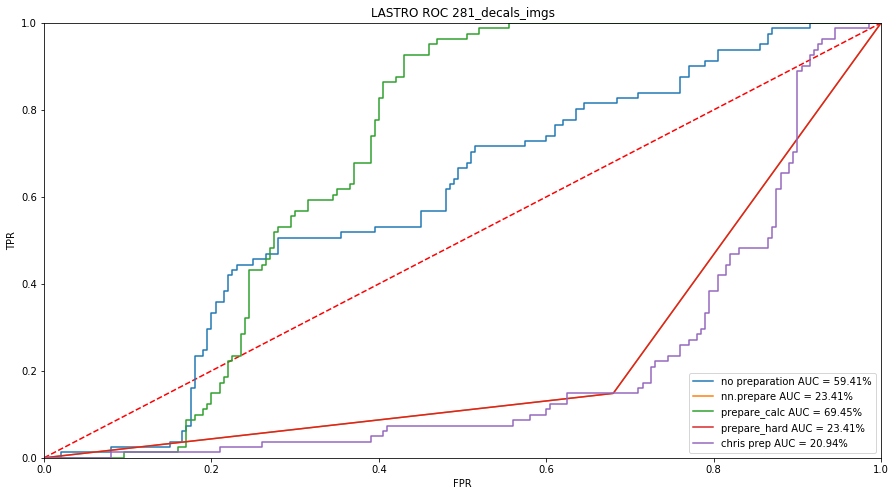

In [242]:
# plot ROC for model_10000 on decals images
x_np = decals_set_281

# chris pre-processing
x_chris = decals_set_281.ravel()
x_chris*=3
clip = 5
x_chris = np.clip(x_chris, -clip, clip)*20
x_chris = x_chris.reshape(-1,101,101,3)

x_p = nn.prepare(x_np)
x_pc = prepare_calc(x_np)
x_ph = prepare_hard(x_np)
x_tests = [x_np, x_p, x_pc, x_ph, x_chris]
labels = ['no preparation', 'nn.prepare', 'prepare_calc', 'prepare_hard', 'chris prep']
plot_roc(outfile_10000, nn_10000, sess_10000, x_tests, y_decals_set_281, idx='281_decals_imgs', labels=labels, savefig=True)

### plot roc for model_320 iteration 27200 on ground-based images (sets of 1000)

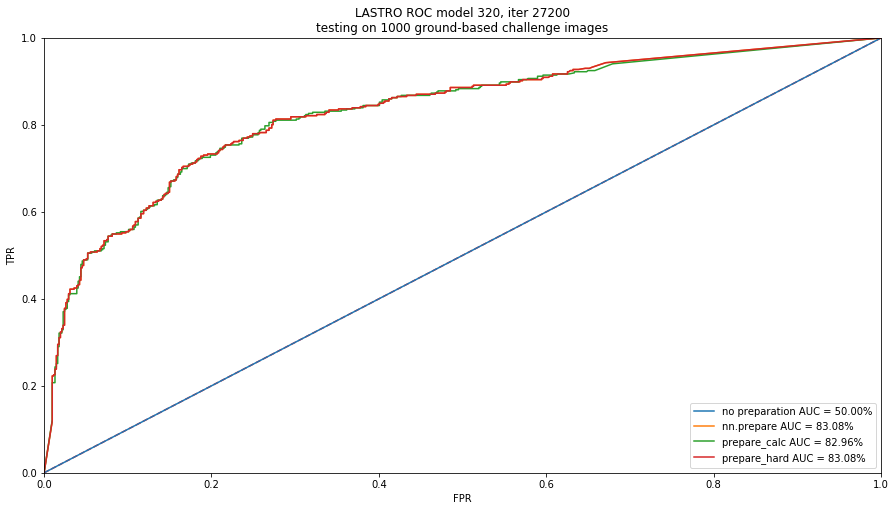

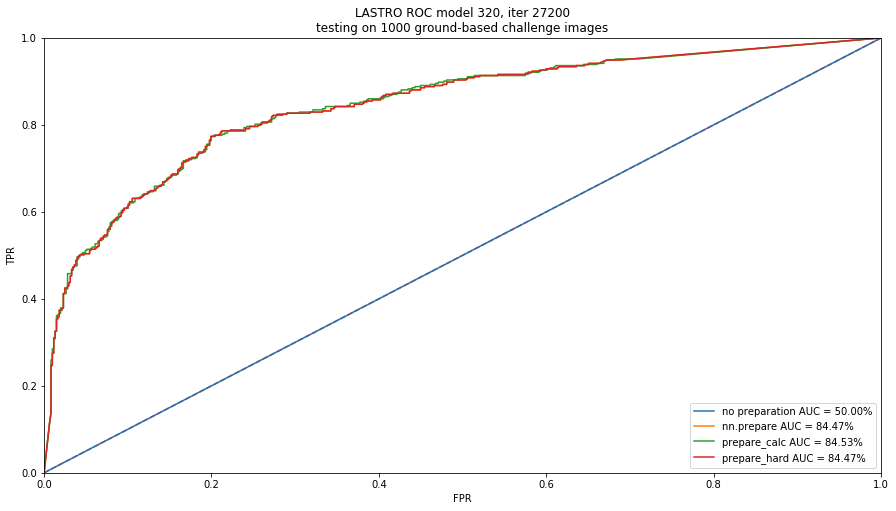

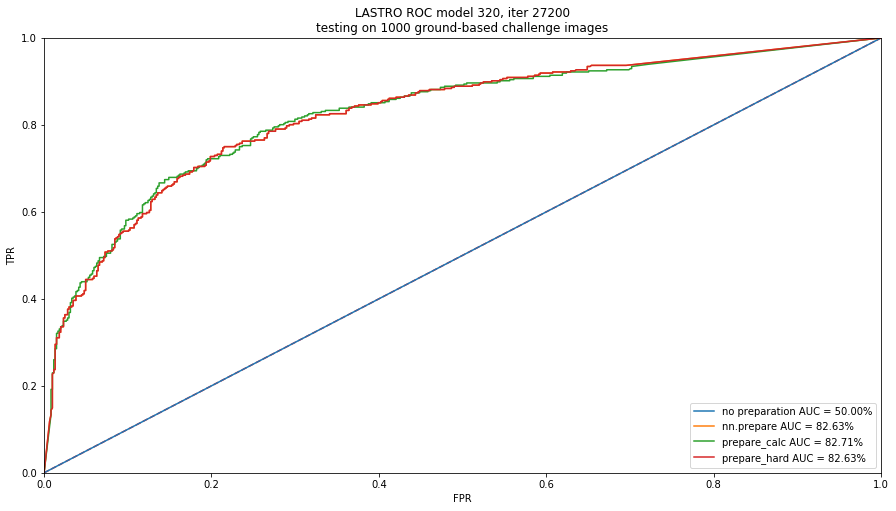

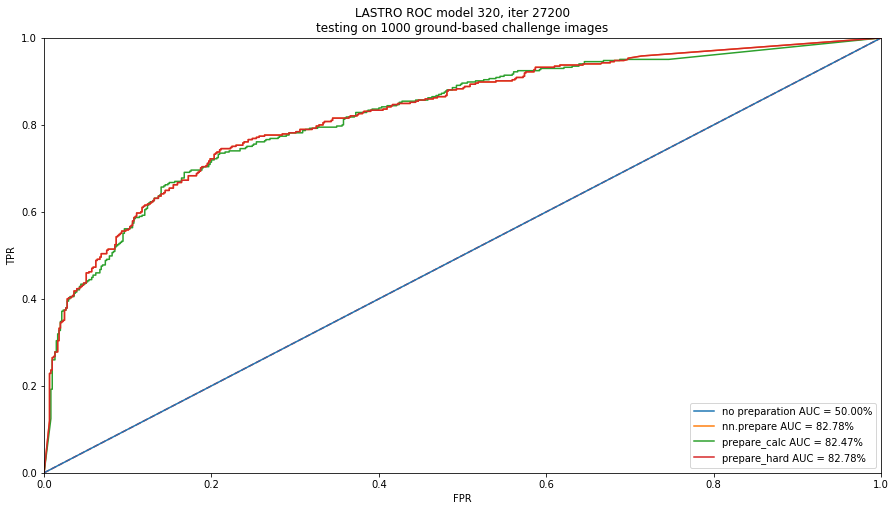

KeyboardInterrupt: 

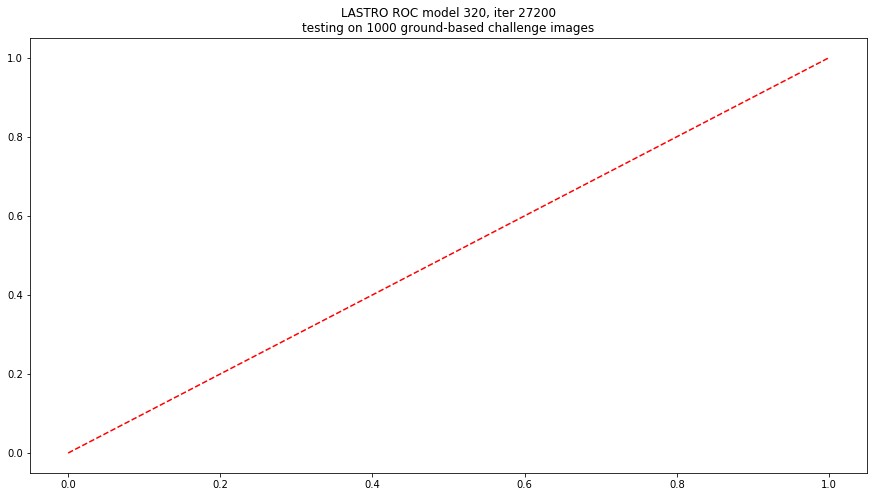

In [22]:
# plot 5 ROC curves for finished LASTRO model_32o, with 1000img sets
for i in range(5):
    y_test = y[10000+(i*1000):11000+(i*1000)]
    x_np = x[10000+(i*1000):11000+(i*1000)]
    x_p = nn_320.prepare(x_np)
    x_pc = prepare_calc(x_np)
    x_ph = prepare_hard(x_np)
    x_tests = [x_np, x_p, x_pc, x_ph]
    labels = ['no preparation', 'nn.prepare', 'prepare_calc', 'prepare_hard']
    plot_roc(outfile_320, nn_320, sess_320, x_tests, y_test, idx='model 320, iter 27200\ntesting on 1000 ground-based challenge images', labels=labels, savefig=False)

### plot auc for model 320 iter 27200 

INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/check_model_progress/iter/000100.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/check_model_progress/iter/002500.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/check_model_progress/iter/004900.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/check_model_progress/iter/007300.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/check_model_progress/iter/009700.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/check_model_progress/iter/012100.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/check_model_progress/iter/014500.data
INFO:tensorflow:Restoring parameters from /Users/mac/Desktop/LBNL/lensfinder-euclid-master/check_

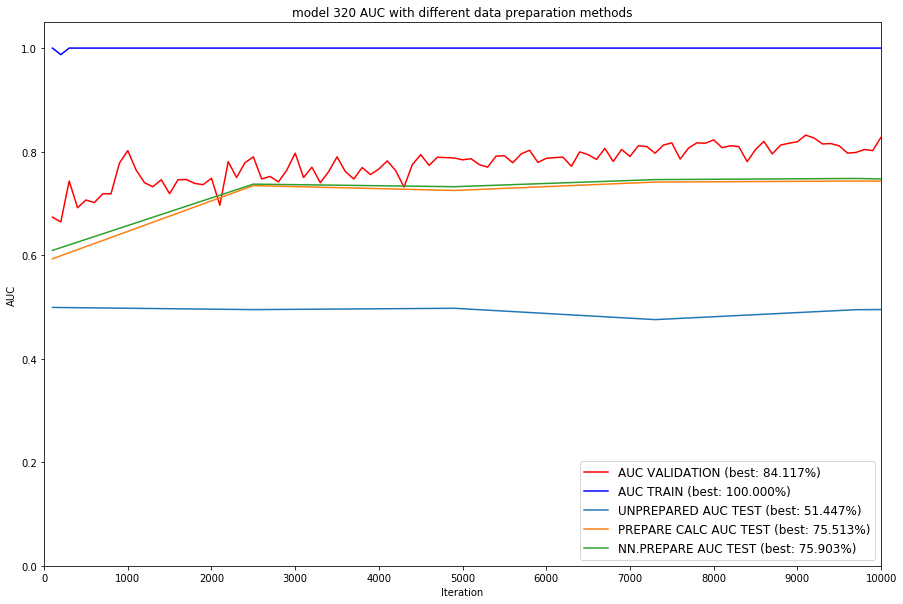

In [163]:
# plot AUC for LASTRO model_320, with 500 image set for new auc plot (unseen test data over iteration)
plot_auc(outfile_320, arch_path, bands, n_train_model=320, plot_xent=False, get_unseen=True, x_test=x[5000:5200], y_test=y[5000:5200] , n_iters=20, title='model 320 AUC with different data preparation methods')

### testing my own ROC function

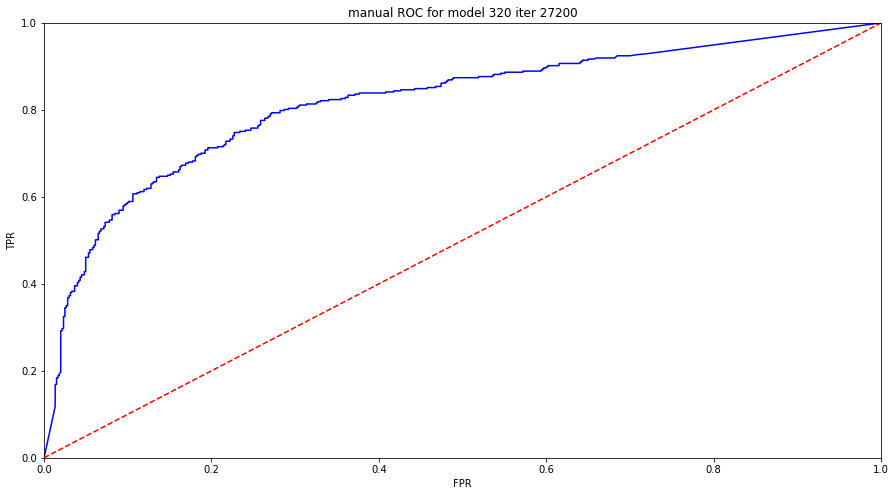

In [72]:
# model 320_1
targs_roctest = y[1000:2000]
x_roctest = x[1000:2000]
x_roctest = prepare_calc(x_roctest)
preds_roctest = nn_320_1.predict(sess_320_1, x_roctest)
roc_manual(preds_roctest, targs_roctest, title='manual ROC for model 320_1')

In [103]:
'''
Here I am just demonstrating how removing datapoints with opposite targets that received the same prediction,
you can eliminate the angled lines within the ROC curve and just get horizontal/vertical progression.

'''
# model 320_1
idxs = []
preds = []
check = []
for i_c, pred_c in enumerate(preds_roctest):
    for i, pred in enumerate(preds_roctest):
        if i_c != i and pred_c == pred and targs_roctest[i_c] != targs_roctest[i] and i not in idxs and i_c not in idxs:
            idxs.append(i)
            preds.append(pred)
            check.append([i_c, pred_c, targs_roctest[i_c], i, pred, targs_roctest[i]])
print(len(idxs), 'duplicate predictions for opposite targets')

preds_roctest_nodup = copy.copy(preds_roctest)
targs_roctest_nodup = copy.copy(targs_roctest)
print('shape before removing duplicates:',preds_roctest_nodup.shape)
for i in sorted(idxs, reverse=True):
    preds_roctest_nodup = np.delete(preds_roctest_nodup, i, 0)
    targs_roctest_nodup = np.delete(targs_roctest_nodup, i, 0)
print('shape after removing duplicates:',preds_roctest_nodup.shape)

43 duplicate predictions for opposite targets
shape before removing duplicates: (1000,)
shape after removing duplicates: (957,)


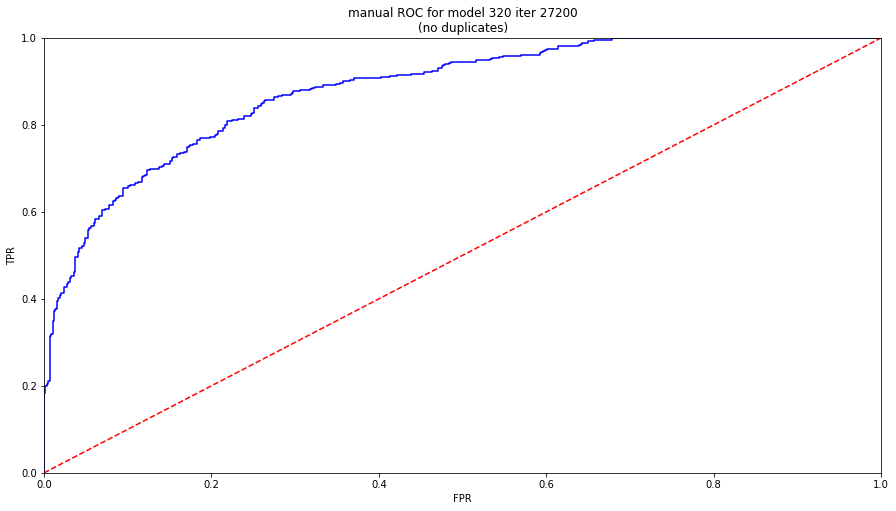

In [102]:
# model 320_1
roc_manual(preds_roctest_nodup, targs_roctest_nodup, title='manual ROC for model 320_1\n(no duplicates)')

In [110]:
# model 320_1
prob = preds_roctest
prob_0 = [] # lens
prob_1 = [] # nonlens
for i in range(prob.shape[0]):
    if targs_roctest[i] == 0.: #nonlens
        prob_1.append(prob[i])
    elif targs_roctest[i] == 1.: #lens
        prob_0.append(prob[i])
prob_0 = np.asarray(prob_0)
prob_1 = np.asarray(prob_1)
print(prob.shape, prob_0.shape, prob_1.shape)

(1000,) (397,) (603,)


lens 90th: 1.000000
lens 80th: 0.999994
lens 70th: 0.999395
lens 60th: 0.932350
lens 50th: 0.014957
lens 40th: 0.000000
lens 30th: 0.000000
lens 20th: 0.000000
lens 10th: 0.000000
non-lens 90th: 2.33e-10
non-lens 80th: 3.73e-25
non-lens 70th: 2.15e-33
non-lens 60th: 1.45e-37
non-lens 50th: 1.46e-40
non-lens 40th: 7.84e-43
non-lens 30th: 3.64e-45
non-lens 20th: 0.00e+00
non-lens 10th: 0.00e+00


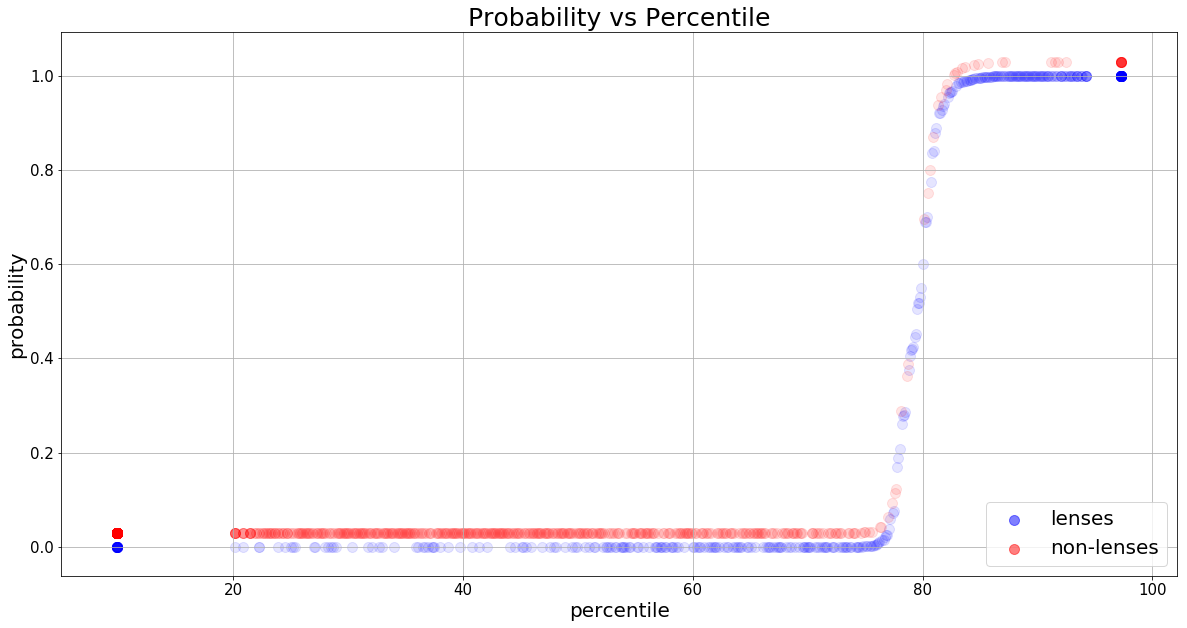

In [171]:
# model 320_1
plt.figure(figsize = (20,10))
plt.title('Probability vs Percentile', fontsize = 25)
plt.xlabel('percentile', fontsize = 20)
plt.ylabel('probability', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
# ax.set_yscale('log')

for i in range(397):
#     ax.scatter(scipy.stats.percentileofscore(prob,prob_0[i]),(prob_0[i]),color = 'blue', alpha=0.4, s = 100)
    if i == 396:
        ax.scatter(scipy.stats.percentileofscore(prob,prob_0[i]),(prob_0[i]),color = 'blue', alpha=0.5, s = 100,label='lenses')
    ax.scatter(scipy.stats.percentileofscore(prob,prob_0[i]),(prob_0[i]),color = 'blue', alpha=0.1, s = 100,)
    plt.grid(True)

for j in range(603):
#     ax.scatter(scipy.stats.percentileofscore(prob,prob_1[j]),(prob_1[j]), color = 'red', alpha=0.4, s = 100)
    if j == 602:
        ax.scatter(scipy.stats.percentileofscore(prob,prob_1[j]),(prob_1[j])+.03, color = 'red', alpha=0.5, s = 100, label='non-lenses')
    ax.scatter(scipy.stats.percentileofscore(prob,prob_1[j]),(prob_1[j])+.03, color = 'red', alpha=0.1, s = 100)
    plt.grid(True)

plt.legend(loc='lower right', fontsize=20)

for k in range(9):
    print('lens {}th: {:06f}'.format(100 - ((k+1)*10),np.percentile(prob_0,100 - ((k+1)*10))))

for k in range(9):
    print('non-lens {}th: {:.2e}'.format(100 - ((k+1)*10),np.percentile(prob_1,100 - ((k+1)*10))))

# x = np.linspace(0,100,101) 
# y = 1 / (1 + np.exp(-((x*0.2)-14.5)))
# plt.plot(x, y, linestyle = '--', color = 'green')
plt.show()

In [141]:
preds_sorted = [(i,p) for i,p in enumerate(preds_roctest)]
preds_sorted = sorted(ppp, key = lambda x: x[1])
print(preds_sorted[:10])

[(3, 0.0), (12, 0.0), (15, 0.0), (24, 0.0), (33, 0.0), (36, 0.0), (37, 0.0), (41, 0.0), (53, 0.0), (55, 0.0)]


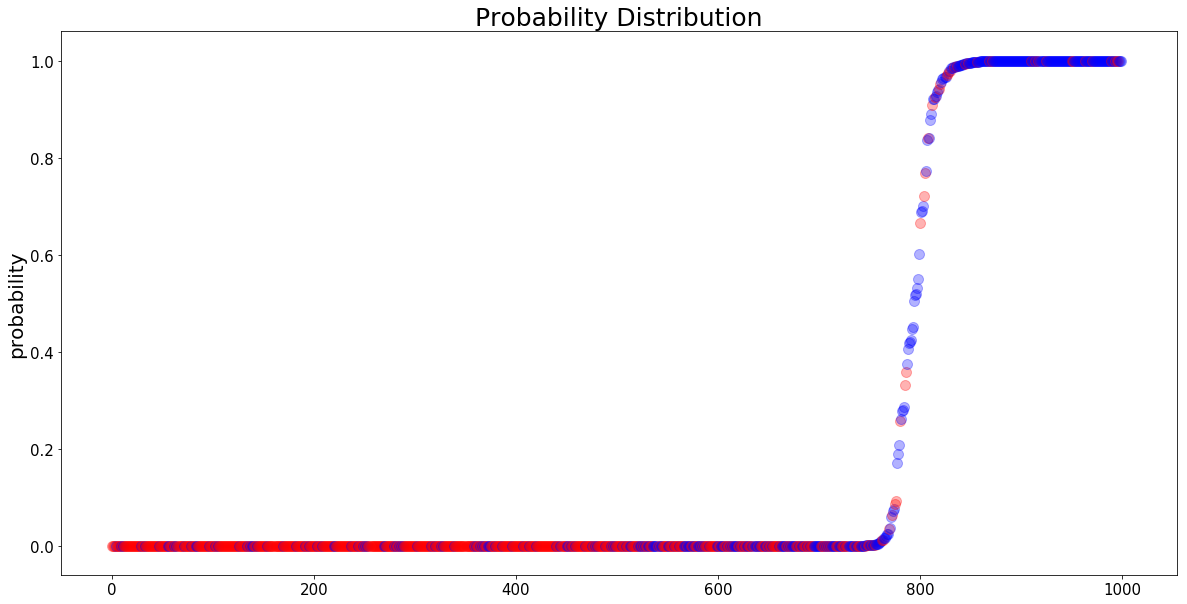

In [147]:
# model 320_1
plt.figure(figsize = (20,10))
plt.title('Probability Distribution', fontsize = 25)
plt.ylabel('probability', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for i in range(len(preds_sorted)):
    if targs_roctest[preds_sorted[i][0]] == 1:
        plt.scatter(i, preds_sorted[i][1], color = 'blue', alpha=0.3, s = 100)
    elif targs_roctest[preds_sorted[i][0]] == 0:
        plt.scatter(i, preds_sorted[i][1], color = 'red', alpha=0.3, s = 100)
plt.show()

### plot ROC for 320 models on challenge and decals data

In [21]:
# make sure challenge data set is defined correctly
challenge_set_1000 = x[18000:19000]
y_challenge_set_1000 = y[18000:19000]
# cs = challenge set
# ds or nothing = decals set

### model 320_1 plots

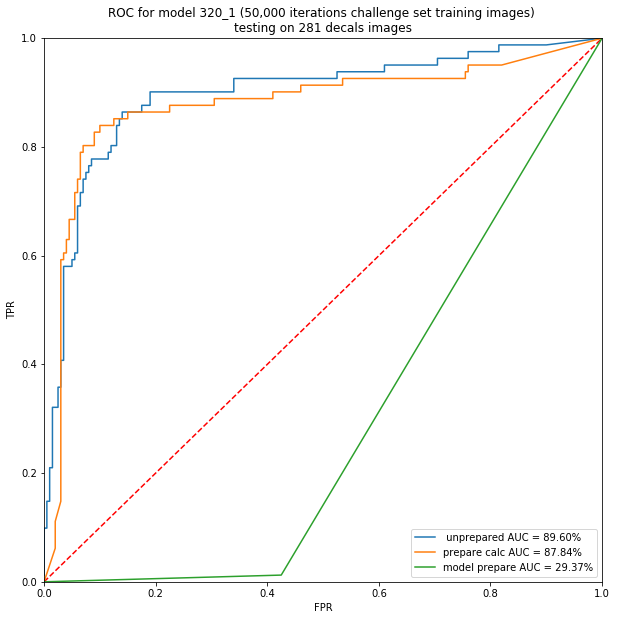

In [266]:
# model 320_1 decals - unprep, prep calc, nn prep

preds_320_1 = nn_320_1.predict(sess_320_1, decals_set_281)
fpr_320_1, tpr_320_1, threshold_320_1 = roc_curve(y_decals_set_281, preds_320_1)
roc_auc_320_1 = metrics.auc(fpr_320_1, tpr_320_1)

preds_320_1_pc = nn_320_1.predict(sess_320_1, prepare_calc(decals_set_281))
fpr_320_1_pc, tpr_320_1_pc, threshold_320_1_pc = roc_curve(y_decals_set_281, preds_320_1_pc)
roc_auc_320_1_pc = metrics.auc(fpr_320_1_pc, tpr_320_1_pc)

preds_320_1_nnp = nn_320_1.predict(sess_320_1, nn_320_1.prepare(decals_set_281))
fpr_320_1_nnp, tpr_320_1_nnp, threshold_320_1_nnp = roc_curve(y_decals_set_281, preds_320_1_nnp)
roc_auc_320_1_nnp = metrics.auc(fpr_320_1_nnp, tpr_320_1_nnp)

plt.figure(figsize=(10,10))
plt.title('ROC for model 320_1 (50,000 iterations challenge set training images) \ntesting on 281 decals images')
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr_320_1, tpr_320_1, label=' unprepared AUC = {:0.2f}%'.format(roc_auc_320_1*100))
plt.plot(fpr_320_1_pc, tpr_320_1_pc, label='prepare calc AUC = {:0.2f}%'.format(roc_auc_320_1_pc*100))
plt.plot(fpr_320_1_nnp, tpr_320_1_nnp, label='model prepare AUC = {:0.2f}%'.format(roc_auc_320_1_nnp*100))
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

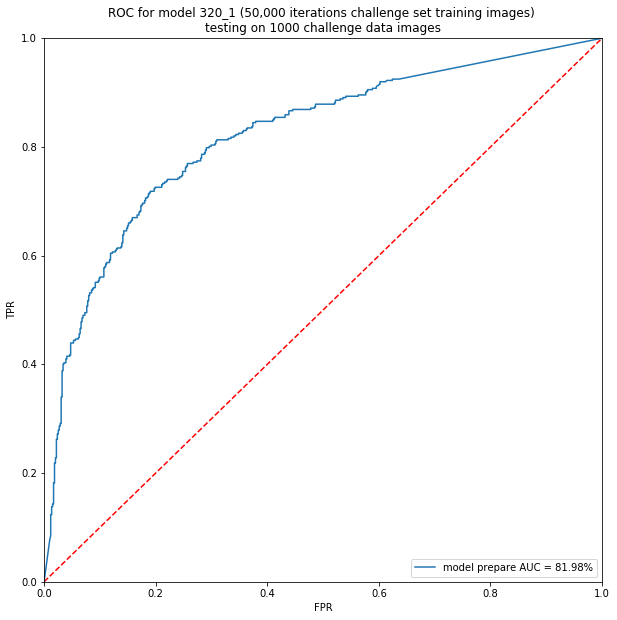

In [269]:
# model 320_1 challenge - nn prep

preds_320_1_cs_nnp = nn_320_1.predict(sess_320_1, nn_320_1.prepare(challenge_set_1000))
fpr_320_1_cs_nnp, tpr_320_1_cs_nnp, threshold_320_1_cs_nnp = roc_curve(y_challenge_set_1000, preds_320_1_cs_nnp)
roc_auc_320_1_cs_nnp = metrics.auc(fpr_320_1_cs_nnp, tpr_320_1_cs_nnp)

plt.figure(figsize=(10,10))
plt.title('ROC for model 320_1 (50,000 iterations challenge set training images) \ntesting on 1000 challenge data images')
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr_320_1_cs_nnp, tpr_320_1_cs_nnp, label='model prepare AUC = {:0.2f}%'.format(roc_auc_320_1_cs_nnp*100))
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

### model 320_2 plots

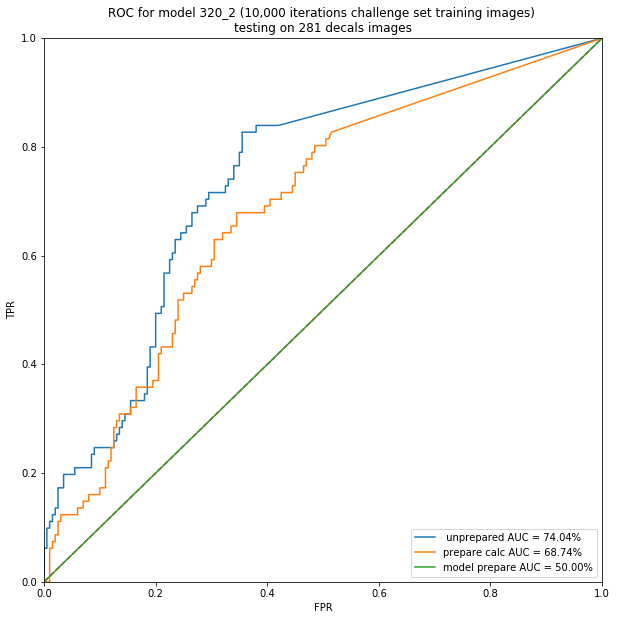

In [270]:
# model 320_2 decals - unprep, prep calc, nn prep

preds_320_2 = nn_320_2.predict(sess_320_2, decals_set_281)
fpr_320_2, tpr_320_2, threshold_320_2 = roc_curve(y_decals_set_281, preds_320_2)
roc_auc_320_2 = metrics.auc(fpr_320_2, tpr_320_2)

preds_320_2_pc = nn_320_2.predict(sess_320_2, prepare_calc(decals_set_281))
fpr_320_2_pc, tpr_320_2_pc, threshold_320_2_pc = roc_curve(y_decals_set_281, preds_320_2_pc)
roc_auc_320_2_pc = metrics.auc(fpr_320_2_pc, tpr_320_2_pc)

preds_320_2_nnp = nn_320_2.predict(sess_320_2, nn_320_2.prepare(decals_set_281))
fpr_320_2_nnp, tpr_320_2_nnp, threshold_320_2_nnp = roc_curve(y_decals_set_281, preds_320_2_nnp)
roc_auc_320_2_nnp = metrics.auc(fpr_320_2_nnp, tpr_320_2_nnp)

plt.figure(figsize=(10,10))
plt.title('ROC for model 320_2 (10,000 iterations challenge set training images) \ntesting on 281 decals images')
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr_320_2, tpr_320_2, label=' unprepared AUC = {:0.2f}%'.format(roc_auc_320_2*100))
plt.plot(fpr_320_2_pc, tpr_320_2_pc, label='prepare calc AUC = {:0.2f}%'.format(roc_auc_320_2_pc*100))
plt.plot(fpr_320_2_nnp, tpr_320_2_nnp, label='model prepare AUC = {:0.2f}%'.format(roc_auc_320_2_nnp*100))
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

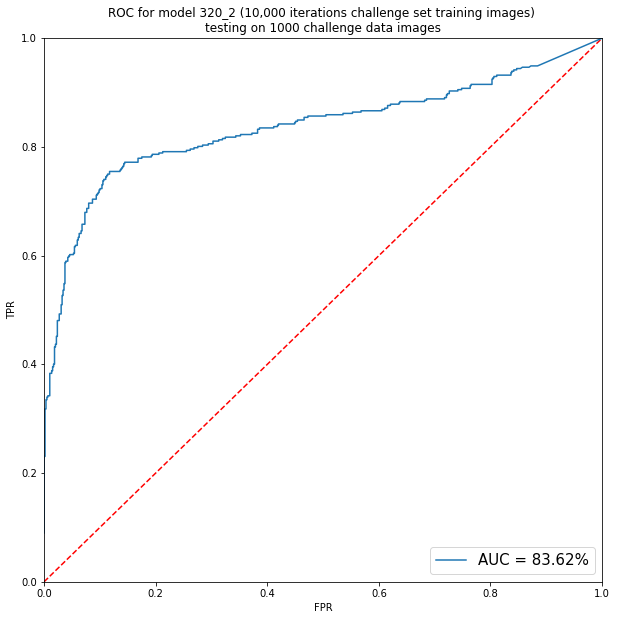

In [27]:
# model 320_2 challenge - nn prep

preds_320_2_cs_nnp = nn_320_2.predict(sess_320_2, nn_320_2.prepare(challenge_set_1000))
fpr_320_2_cs_nnp, tpr_320_2_cs_nnp, threshold_320_2_cs_nnp = metrics.roc_curve(y_challenge_set_1000, preds_320_2_cs_nnp)
roc_auc_320_2_cs_nnp = metrics.auc(fpr_320_2_cs_nnp, tpr_320_2_cs_nnp)

plt.figure(figsize=(10,10))
plt.title('ROC for model 320_2 (10,000 iterations challenge set training images) \ntesting on 1000 challenge data images')
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr_320_2_cs_nnp, tpr_320_2_cs_nnp, label='AUC = {:0.2f}%'.format(roc_auc_320_2_cs_nnp*100))
plt.legend(loc='lower right', fontsize=15)
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

### model 320_3 plots

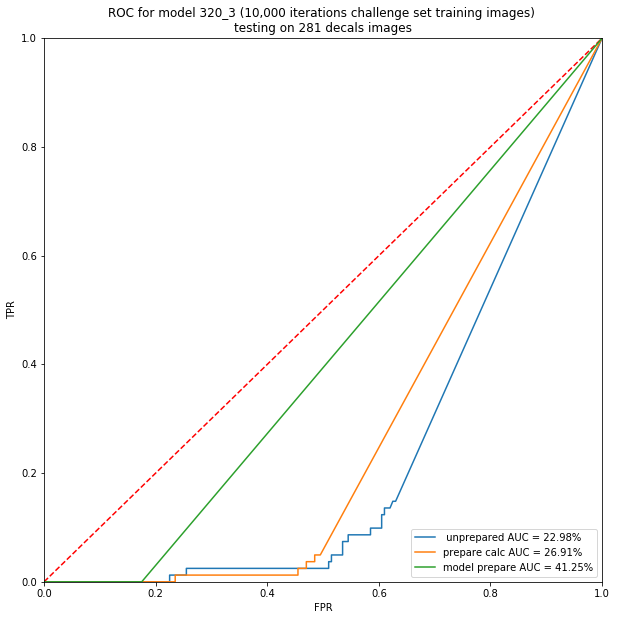

In [273]:
# model 320_3 decals - unprep, prep calc, nn prep

preds_320_3 = nn_320_3.predict(sess_320_3, decals_set_281)
fpr_320_3, tpr_320_3, threshold_320_3 = roc_curve(y_decals_set_281, preds_320_3)
roc_auc_320_3 = metrics.auc(fpr_320_3, tpr_320_3)

preds_320_3_pc = nn_320_3.predict(sess_320_3, prepare_calc(decals_set_281))
fpr_320_3_pc, tpr_320_3_pc, threshold_320_3_pc = roc_curve(y_decals_set_281, preds_320_3_pc)
roc_auc_320_3_pc = metrics.auc(fpr_320_3_pc, tpr_320_3_pc)

preds_320_3_nnp = nn_320_3.predict(sess_320_3, nn_320_3.prepare(decals_set_281))
fpr_320_3_nnp, tpr_320_3_nnp, threshold_320_3_nnp = roc_curve(y_decals_set_281, preds_320_3_nnp)
roc_auc_320_3_nnp = metrics.auc(fpr_320_3_nnp, tpr_320_3_nnp)

plt.figure(figsize=(10,10))
plt.title('ROC for model 320_3 (10,000 iterations challenge set training images) \ntesting on 281 decals images')
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr_320_3, tpr_320_3, label=' unprepared AUC = {:0.2f}%'.format(roc_auc_320_3*100))
plt.plot(fpr_320_3_pc, tpr_320_3_pc, label='prepare calc AUC = {:0.2f}%'.format(roc_auc_320_3_pc*100))
plt.plot(fpr_320_3_nnp, tpr_320_3_nnp, label='model prepare AUC = {:0.2f}%'.format(roc_auc_320_3_nnp*100))
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [19]:
# model 320_3 challenge - nn prep

preds_320_3_cs_nnp = nn_320_3.predict(sess_320_3, nn_320_3.prepare(challenge_set_1000))
fpr_320_3_cs_nnp, tpr_320_3_cs_nnp, threshold_320_3_cs_nnp = roc_curve(y_challenge_set_1000, preds_320_3_cs_nnp)
roc_auc_320_3_cs_nnp = metrics.auc(fpr_320_3_cs_nnp, tpr_320_3_cs_nnp)

plt.figure(figsize=(10,10))
plt.title('ROC for model 320_3 (10,000 iterations challenge set training images) \ntesting on 1000 challenge data images')
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr_320_3_cs_nnp, tpr_320_3_cs_nnp, label='model prepare AUC = {:0.2f}%'.format(roc_auc_320_3_cs_nnp*100))
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

NameError: name 'nn_320_3' is not defined

### model 10000 plots

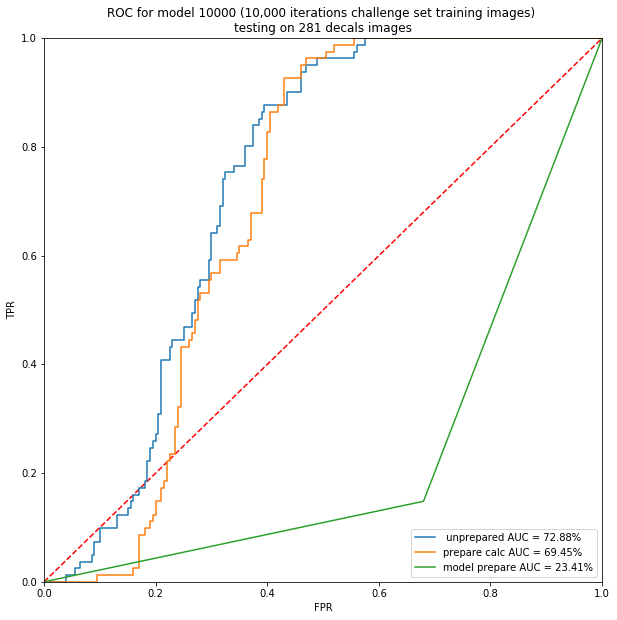

In [283]:
# model 10000 decals - unprep, prep calc, nn prep

preds_10000 = nn_10000.predict(sess_10000, decals_set_281)
fpr_10000, tpr_10000, threshold_10000 = roc_curve(y_decals_set_281, preds_10000)
roc_auc_10000 = metrics.auc(fpr_10000, tpr_10000)

preds_10000_pc = nn_10000.predict(sess_10000, prepare_calc(decals_set_281))
fpr_10000_pc, tpr_10000_pc, threshold_10000_pc = roc_curve(y_decals_set_281, preds_10000_pc)
roc_auc_10000_pc = metrics.auc(fpr_10000_pc, tpr_10000_pc)

preds_10000_nnp = nn_10000.predict(sess_10000, nn_10000.prepare(decals_set_281))
fpr_10000_nnp, tpr_10000_nnp, threshold_10000_nnp = roc_curve(y_decals_set_281, preds_10000_nnp)
roc_auc_10000_nnp = metrics.auc(fpr_10000_nnp, tpr_10000_nnp)

plt.figure(figsize=(10,10))
plt.title('ROC for model 10000 (10,000 iterations challenge set training images) \ntesting on 281 decals images')
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr_10000, tpr_10000, label=' unprepared AUC = {:0.2f}%'.format(roc_auc_10000*100))
plt.plot(fpr_10000_pc, tpr_10000_pc, label='prepare calc AUC = {:0.2f}%'.format(roc_auc_10000_pc*100))
plt.plot(fpr_10000_nnp, tpr_10000_nnp, label='model prepare AUC = {:0.2f}%'.format(roc_auc_10000_nnp*100))
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

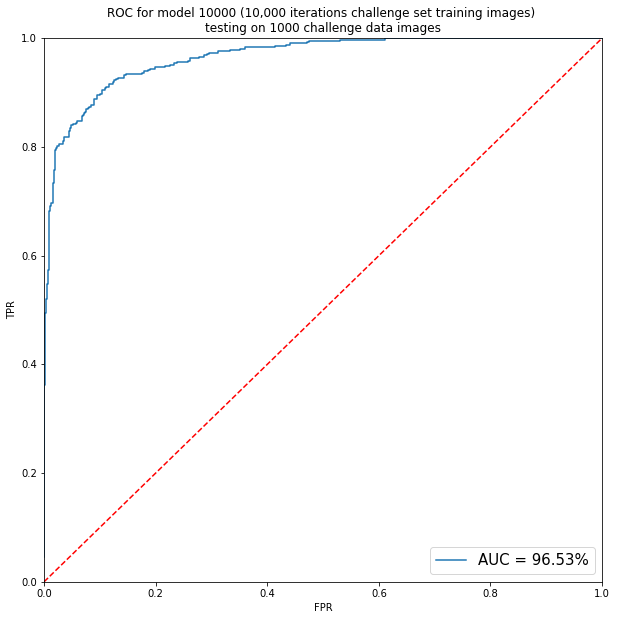

In [26]:
# model 10000 challenge - nn prep

preds_10000_cs_nnp = nn_10000.predict(sess_10000, nn_10000.prepare(challenge_set_1000))
fpr_10000_cs_nnp, tpr_10000_cs_nnp, threshold_10000_cs_nnp = metrics.roc_curve(y_challenge_set_1000, preds_10000_cs_nnp)
roc_auc_10000_cs_nnp = metrics.auc(fpr_10000_cs_nnp, tpr_10000_cs_nnp)

plt.figure(figsize=(10,10))
plt.title('ROC for model 10000 (10,000 iterations challenge set training images) \ntesting on 1000 challenge data images')
plt.plot([0,1], [0,1], 'r--')
plt.plot(fpr_10000_cs_nnp, tpr_10000_cs_nnp, label='AUC = {:0.2f}%'.format(roc_auc_10000_cs_nnp*100))
plt.legend(loc='lower right', fontsize=15)
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

### plot model_1 at different iterations

In [ ]:
# specify variables for model_10000, load in base architecture, initialize with values
outfile_320_1 = '/Users/mac/Desktop/LBNL/lensfinder-euclid-master/output_50000_320_1_3band_finished/'
arch_path = 'arch_baseline_amount_3band.py'
iteration = '050000'
bands = 3

graph_320_1, nn_320_1 = load_arch(arch_path, bands)
sess_320_1 = tf.Session(graph=graph_320_1)
load_backup(sess_320_1, graph_320_1, outfile_320_1+'iter/{}.data'.format(iteration))

In [ ]:
# model 320_1 decals - unprep, prep calc, nn prep
for iteration in ['000500', '001000', '010000', '020000', '030000', '040000']
    
    graph_temp, nn_temp = load_arch(arch_path, bands)
    sess_temp = tf.Session(graph=graph_temp)
    load_backup(sess_temp, graph_temp, outfile_temp+'iter/{}.data'.format(iteration))

    preds_temp_up = nn_temp.predict(sess_temp, decals_set_281)
    fpr_temp_up, tpr_temp_up, threshold_temp_up = roc_curve(y_decals_set_281, preds_temp_up)
    roc_auc_temp_up = metrics.auc(fpr_temp_up, tpr_temp_up)

    preds_temp_pc = nn_temp.predict(sess_temp, prepare_calc(decals_set_281))
    fpr_temp_pc, tpr_temp_pc, threshold_temp_pc = roc_curve(y_decals_set_281, preds_temp_pc)
    roc_auc_temp_pc = metrics.auc(fpr_temp_pc, tpr_temp_pc)

    plt.figure(figsize=(10,10))
    plt.title('ROC for model 320_1 at iteration {} \ntesting on 281 decals images'.format(iteration))
    plt.plot([0,1], [0,1], 'r--')
    plt.plot(fpr_temp_up, tpr_temp_up, label=' unprepared AUC = {:0.2f}%'.format(roc_auc_temp_up*100))
    plt.plot(fpr_temp_pc, tpr_temp_pc, label='prepare calc AUC = {:0.2f}%'.format(roc_auc_temp_pc*100))
    plt.legend(loc='lower right')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()